In [4]:
!pip install MissForest
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


# MODELO ENSAMBLADO CATBOOST - LGBM

Se realizó un modelo ensamblado, buscando el mejor peso entre las probabilidades obtenidad entre los modelos CATBOOST y LGBM. Los resultados del ensamble se encuentran en el notebook "ENSAMBLE_PREDICCION_FINAL" y ahi se encuentran las conclusiones finales.

## MODELO CATBOOST

#### Importación de las librerías necesarias para el análisis.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,roc_curve,auc,classification_report
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_recall_curve, average_precision_score,precision_score
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
import missingno as msno

from sklearn import preprocessing

from missforest import MissForest

import warnings
warnings.filterwarnings('ignore')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importación de tablas.

In [7]:
# Data set
train_df = pd.read_csv("/content/drive/MyDrive/DATATHON - 2/train.csv", sep = ",")
test_df_private = pd.read_csv("/content/drive/MyDrive/DATATHON - 2/test_private.csv", sep = ",")
test_df_public = pd.read_csv("/content/drive/MyDrive/DATATHON - 2/test_public.csv", sep = ",")
print('TRAIN')
print(train_df.shape)
print('TEST_PRIVATE')
print(test_df_private.shape)
print('TEST_PUBLIC')
print(test_df_public.shape)

TRAIN
(347246, 28)
TEST_PRIVATE
(43406, 27)
TEST_PUBLIC
(43406, 28)


## TRAIN

### Análisis descriptivo y exploratorio

In [ ]:
print(train_df['ID'].nunique())
train_df.info()
train_df.head()

347246
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347246 entries, 0 to 347245
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CHD_OR_MI            347246 non-null  float64
 1   SEX                  347246 non-null  int64  
 2   AGE                  347246 non-null  int64  
 3   HEALTH               346408 non-null  float64
 4   PHYSICAL_HEALTH      339940 non-null  float64
 5   MENTAL_HEALTH        341212 non-null  float64
 6   PHYSICAL_ACTIVITIES  346593 non-null  float64
 7   BLOOD_PRESSURE       345939 non-null  float64
 8   HIGH_CHOLESTEROL     297055 non-null  float64
 9   SKIN_CANCER          346379 non-null  float64
 10  CANCER               346454 non-null  float64
 11  BRONCHITIS           345933 non-null  float64
 12  DEPRESSIVE_DISORDER  345560 non-null  float64
 13  KIDNEY_DISEASE       346115 non-null  float64
 14  DIABETES             346716 non-null  float64
 15  ARTHRITIS 

,CHD_OR_MI,SEX,AGE,HEALTH,PHYSICAL_HEALTH,MENTAL_HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,SKIN_CANCER,...,SMOKE,TABACCO_PRODUCTS,E_CIGARETTES,HEAVY_DRINKERS,HIV,FRUITS,VEGETABLES,FRIED_POTATOES,ETHNICITY,ID
0,1.0,1,34,1.0,1.0,2.0,1.0,1.0,2.0,2.0,...,2.0,3.0,3.0,1.0,2.0,2.0,1.0,1.0,1,PID2022_316043
1,0.0,1,76,1.0,1.0,1.0,2.0,2.0,1.0,1.0,...,1.0,3.0,4.0,1.0,NaN,2.0,NaN,3.0,1,PID2022_024501
2,1.0,2,69,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,1.0,2.0,2.0,1.0,2.0,2,PID2022_393860
3,1.0,2,36,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,2.0,3.0,3.0,1.0,1.0,1.0,2.0,2.0,5,PID2022_029988
4,1.0,2,21,1.0,1.0,2.0,1.0,1.0,1.0,2.0,...,2.0,3.0,3.0,1.0,2.0,1.0,1.0,2.0,1,PID2022_308442


In [ ]:
info_data = {
    'Tipo de Dato': train_df.dtypes,
    'Valores Nulos': train_df.isnull().sum(),
    'Valores unicos': train_df.nunique(),
    '% Valores Nulos': np.round(train_df.isnull().sum()/train_df.shape[0]*100,2),
    'Valores No Nulos': train_df.notnull().sum()
}

# Creando el DataFrame
estructura_datos = pd.DataFrame(info_data)
estructura_datos.sort_values('% Valores Nulos', ascending=False)

,Tipo de Dato,Valores Nulos,Valores unicos,% Valores Nulos,Valores No Nulos
HIGH_CHOLESTEROL,float64,50191,2,14.45,297055
VEGETABLES,float64,47387,2,13.65,299859
HIV,float64,40794,2,11.75,306452
FRUITS,float64,40254,2,11.59,306992
BMI,float64,36960,3702,10.64,310286
FRIED_POTATOES,float64,35302,3,10.17,311944
HEAVY_DRINKERS,float64,27583,2,7.94,319663
SMOKE,float64,19263,2,5.55,327983
E_CIGARETTES,float64,18884,4,5.44,328362
TABACCO_PRODUCTS,float64,18033,3,5.19,329213


En el análisis de las variables del conjunto de datos, se identificó que la mayoría son binarias o categóricas, con un máximo de cuatro categorías por variable. Asimismo, se detectó la presencia de valores nulos en algunas variables, destacando "HIGH_CHOLESTEROL" como la más afectada, con un 14.45% de datos faltantes, y "DIABETES" como la menos afectada, con solo un 0.15%.

Para abordar este problema, se plantearon dos enfoques principales: la imputación de datos y la creación de una nueva categoría para representar los valores faltantes. Según la documentación, los datos faltantes se deben a tres posibles razones: desconocimiento, rechazo a responder o dependencia de otras variables también nulas, como en el caso de "BMI".

#### Métodos de imputación evaluados:

1. **Imputación con Miss Forest**:
   - Utiliza árboles de decisión, lo que le permite manejar adecuadamente relaciones no lineales e interacciones entre variables.
   - Es compatible con datos mixtos (categóricos y continuos).
   - Minimiza la pérdida de información al evitar la creación de categorías artificiales.

2. **Creación de una nueva categoría** (solo para variables categóricas):
   - Útil cuando el desconocimiento o el rechazo a responder pueden ser informativos por sí mismos.
   - Reduce el riesgo de sesgos al evitar la imputación de valores que podrían no reflejar la realidad.

### Resultados y conclusión:

Se optó por la imputación con Miss Forest, dado que produjo mejores resultados en la métrica F1_score y mayor estabilidad entre los conjuntos de entrenamiento y prueba. Este enfoque demostró ser una solución efectiva al preservar la estructura de los datos y mejorar el desempeño del modelo en el contexto del problema analizado.


#### Distribución del target

In [ ]:
train_df['CHD_OR_MI'].value_counts(normalize=True)*100

,proportion
CHD_OR_MI,
1.0,91.862253
0.0,8.137747


Claramente podemos observar que el target está desvalanceado. Podemos usar una técnica de desbalanceo de clases o usar modelos robustos a este desbalance.

#### Distribución de variables binarias y categóricas.

In [5]:
var_1 = train_df.drop(columns = ['AGE','BMI','ID'])

#-------------------------#
Variable CHD_OR_MI
#-------------------------#
           Conteo  Porcentaje (%)
CHD_OR_MI                        
1.0        318988       91.862253
0.0         28258        8.137747


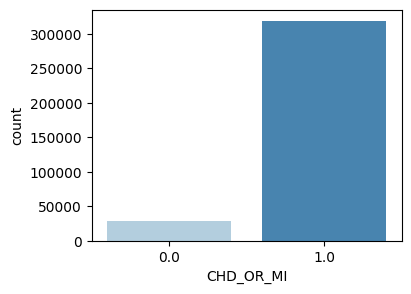

#-------------------------#
Variable SEX
#-------------------------#
     Conteo  Porcentaje (%)
SEX                        
2    185970       53.555693
1    161276       46.444307


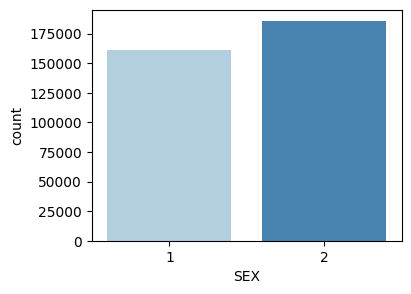

#-------------------------#
Variable HEALTH
#-------------------------#
        Conteo  Porcentaje (%)
HEALTH                        
1.0     289523       83.578613
2.0      56885       16.421387


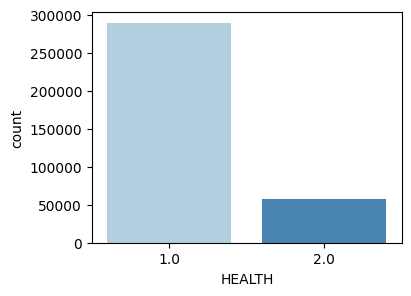

#-------------------------#
Variable PHYSICAL_HEALTH
#-------------------------#
                 Conteo  Porcentaje (%)
PHYSICAL_HEALTH                        
1.0              228286       67.154792
2.0               71772       21.113138
3.0               39882       11.732070


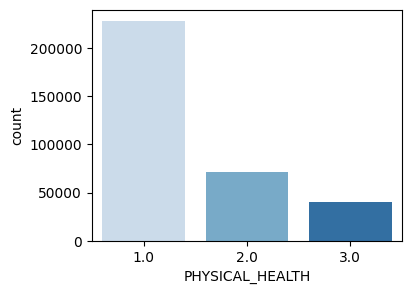

#-------------------------#
Variable MENTAL_HEALTH
#-------------------------#
               Conteo  Porcentaje (%)
MENTAL_HEALTH                        
1.0            214722       62.929205
2.0             82849       24.280799
3.0             43641       12.789996


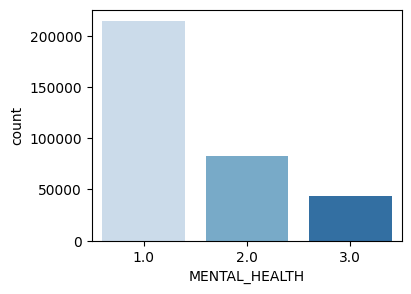

#-------------------------#
Variable PHYSICAL_ACTIVITIES
#-------------------------#
                     Conteo  Porcentaje (%)
PHYSICAL_ACTIVITIES                        
1.0                  262398       75.707819
2.0                   84195       24.292181


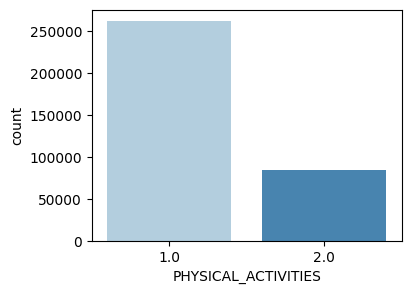

#-------------------------#
Variable BLOOD_PRESSURE
#-------------------------#
                Conteo  Porcentaje (%)
BLOOD_PRESSURE                        
1.0             210318       60.796268
2.0             135621       39.203732


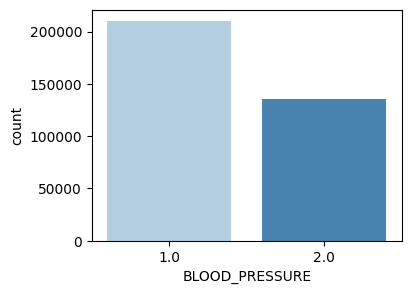

#-------------------------#
Variable HIGH_CHOLESTEROL
#-------------------------#
                  Conteo  Porcentaje (%)
HIGH_CHOLESTEROL                        
2.0               178719       60.163606
1.0               118336       39.836394


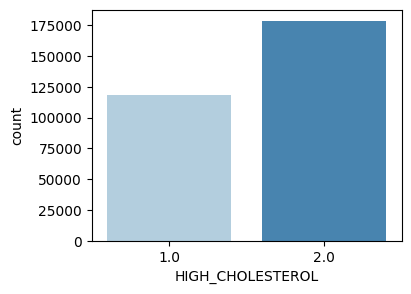

#-------------------------#
Variable SKIN_CANCER
#-------------------------#
             Conteo  Porcentaje (%)
SKIN_CANCER                        
2.0          314042       90.664272
1.0           32337        9.335728


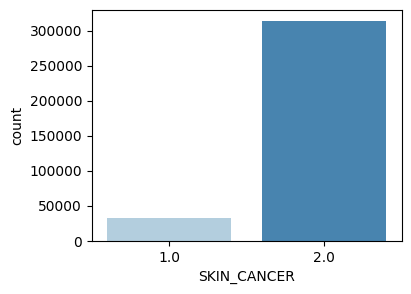

#-------------------------#
Variable CANCER
#-------------------------#
        Conteo  Porcentaje (%)
CANCER                        
2.0     312945       90.328009
1.0      33509        9.671991


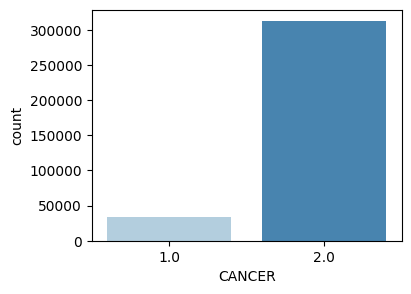

#-------------------------#
Variable BRONCHITIS
#-------------------------#
            Conteo  Porcentaje (%)
BRONCHITIS                        
2.0         319252       92.287235
1.0          26681        7.712765


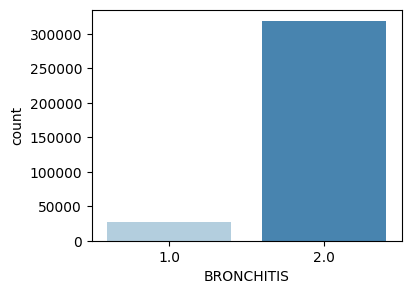

#-------------------------#
Variable DEPRESSIVE_DISORDER
#-------------------------#
                     Conteo  Porcentaje (%)
DEPRESSIVE_DISORDER                        
2.0                  277982       80.443917
1.0                   67578       19.556083


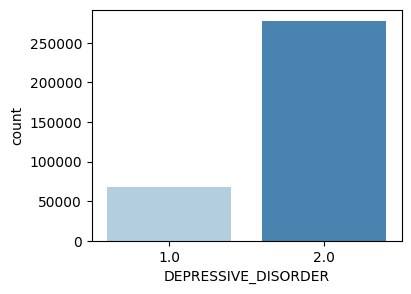

#-------------------------#
Variable KIDNEY_DISEASE
#-------------------------#
                Conteo  Porcentaje (%)
KIDNEY_DISEASE                        
2.0             332724       96.131055
1.0              13391        3.868945


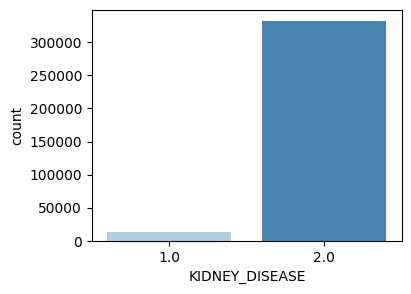

#-------------------------#
Variable DIABETES
#-------------------------#
          Conteo  Porcentaje (%)
DIABETES                        
3.0       290656       83.831147
1.0        45253       13.051893
4.0         7759        2.237855
2.0         3048        0.879106


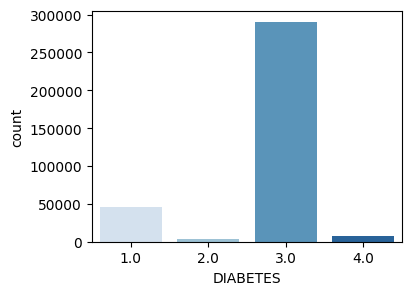

#-------------------------#
Variable ARTHRITIS
#-------------------------#
           Conteo  Porcentaje (%)
ARTHRITIS                        
2.0        233038       67.490124
1.0        112254       32.509876


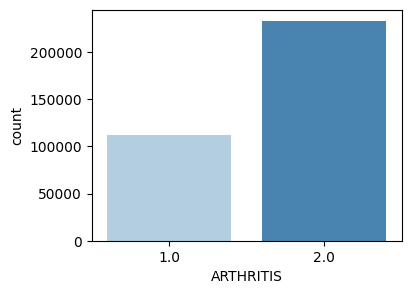

#-------------------------#
Variable DIFFICULTY_WALKING
#-------------------------#
                    Conteo  Porcentaje (%)
DIFFICULTY_WALKING                        
2.0                 278844       84.079821
1.0                  52798       15.920179


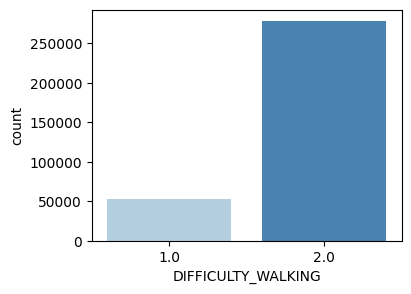

#-------------------------#
Variable SMOKE
#-------------------------#
       Conteo  Porcentaje (%)
SMOKE                        
2.0    195399       59.575954
1.0    132584       40.424046


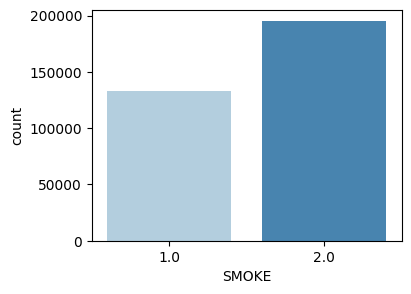

#-------------------------#
Variable TABACCO_PRODUCTS
#-------------------------#
                  Conteo  Porcentaje (%)
TABACCO_PRODUCTS                        
3.0               318762       96.825460
1.0                 6129        1.861713
2.0                 4322        1.312828


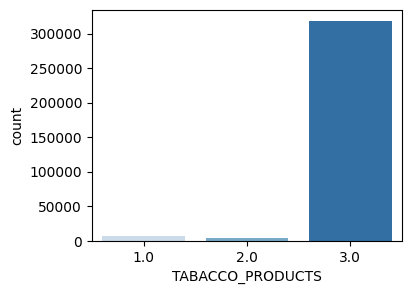

#-------------------------#
Variable E_CIGARETTES
#-------------------------#
              Conteo  Porcentaje (%)
E_CIGARETTES                        
3.0           246536       75.080551
4.0            66476       20.244730
2.0             8149        2.481712
1.0             7201        2.193006


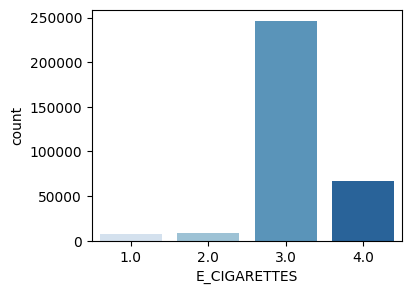

#-------------------------#
Variable HEAVY_DRINKERS
#-------------------------#
                Conteo  Porcentaje (%)
HEAVY_DRINKERS                        
1.0             300696       94.066564
2.0              18967        5.933436


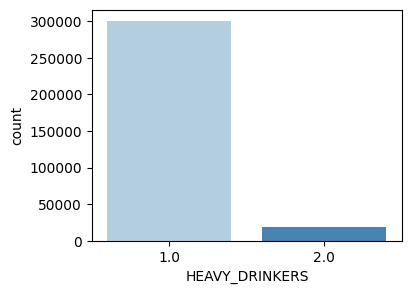

#-------------------------#
Variable HIV
#-------------------------#
     Conteo  Porcentaje (%)
HIV                        
2.0  203876       66.527874
1.0  102576       33.472126


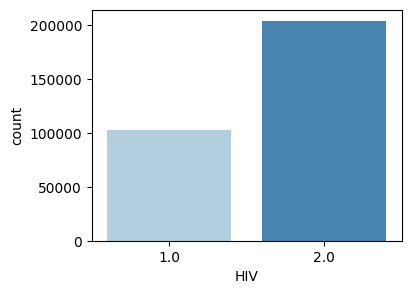

#-------------------------#
Variable FRUITS
#-------------------------#
        Conteo  Porcentaje (%)
FRUITS                        
1.0     189180       61.623756
2.0     117812       38.376244


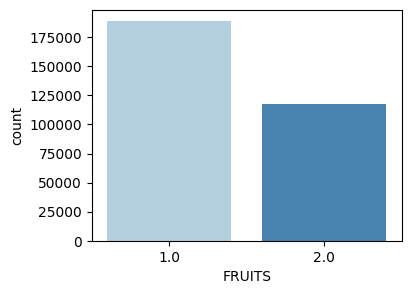

#-------------------------#
Variable VEGETABLES
#-------------------------#
            Conteo  Porcentaje (%)
VEGETABLES                        
1.0         244121        81.41193
2.0          55738        18.58807


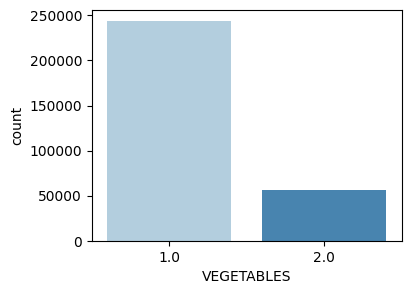

#-------------------------#
Variable FRIED_POTATOES
#-------------------------#
                Conteo  Porcentaje (%)
FRIED_POTATOES                        
1.0             143488       45.998000
2.0             123300       39.526325
3.0              45156       14.475675


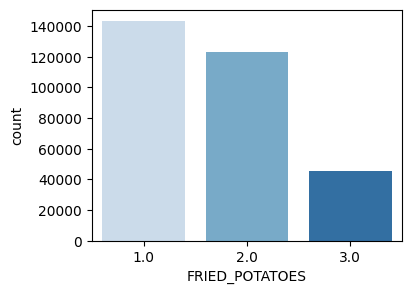

#-------------------------#
Variable ETHNICITY
#-------------------------#
           Conteo  Porcentaje (%)
ETHNICITY                        
1          263254       75.811960
5           30665        8.830915
2           26198        7.544507
6           12354        3.557708
3            9077        2.613997
4            5698        1.640912


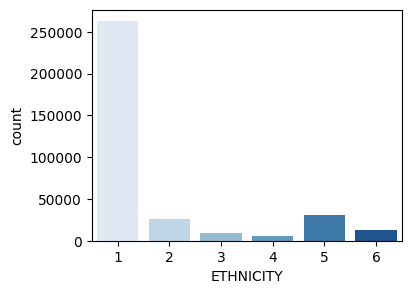

In [ ]:
var_1 = train_df.drop(columns = ['AGE','BMI','ID'])
import seaborn as sns
import matplotlib.pyplot as plt

for i in list(var_1):
    print('#-------------------------#')
    print('Variable',i)
    print('#-------------------------#')

    Porcentajes = train_df[i].value_counts(normalize=True) * 100
    Conteos = train_df[i].value_counts()
    table = pd.DataFrame({
    'Conteo': Conteos,
    'Porcentaje (%)': Porcentajes
    })

    print(table)
    plt.figure(figsize=(4,3))
    sns.countplot(train_df,x = f'{i}',palette = 'Blues')
    plt.show()


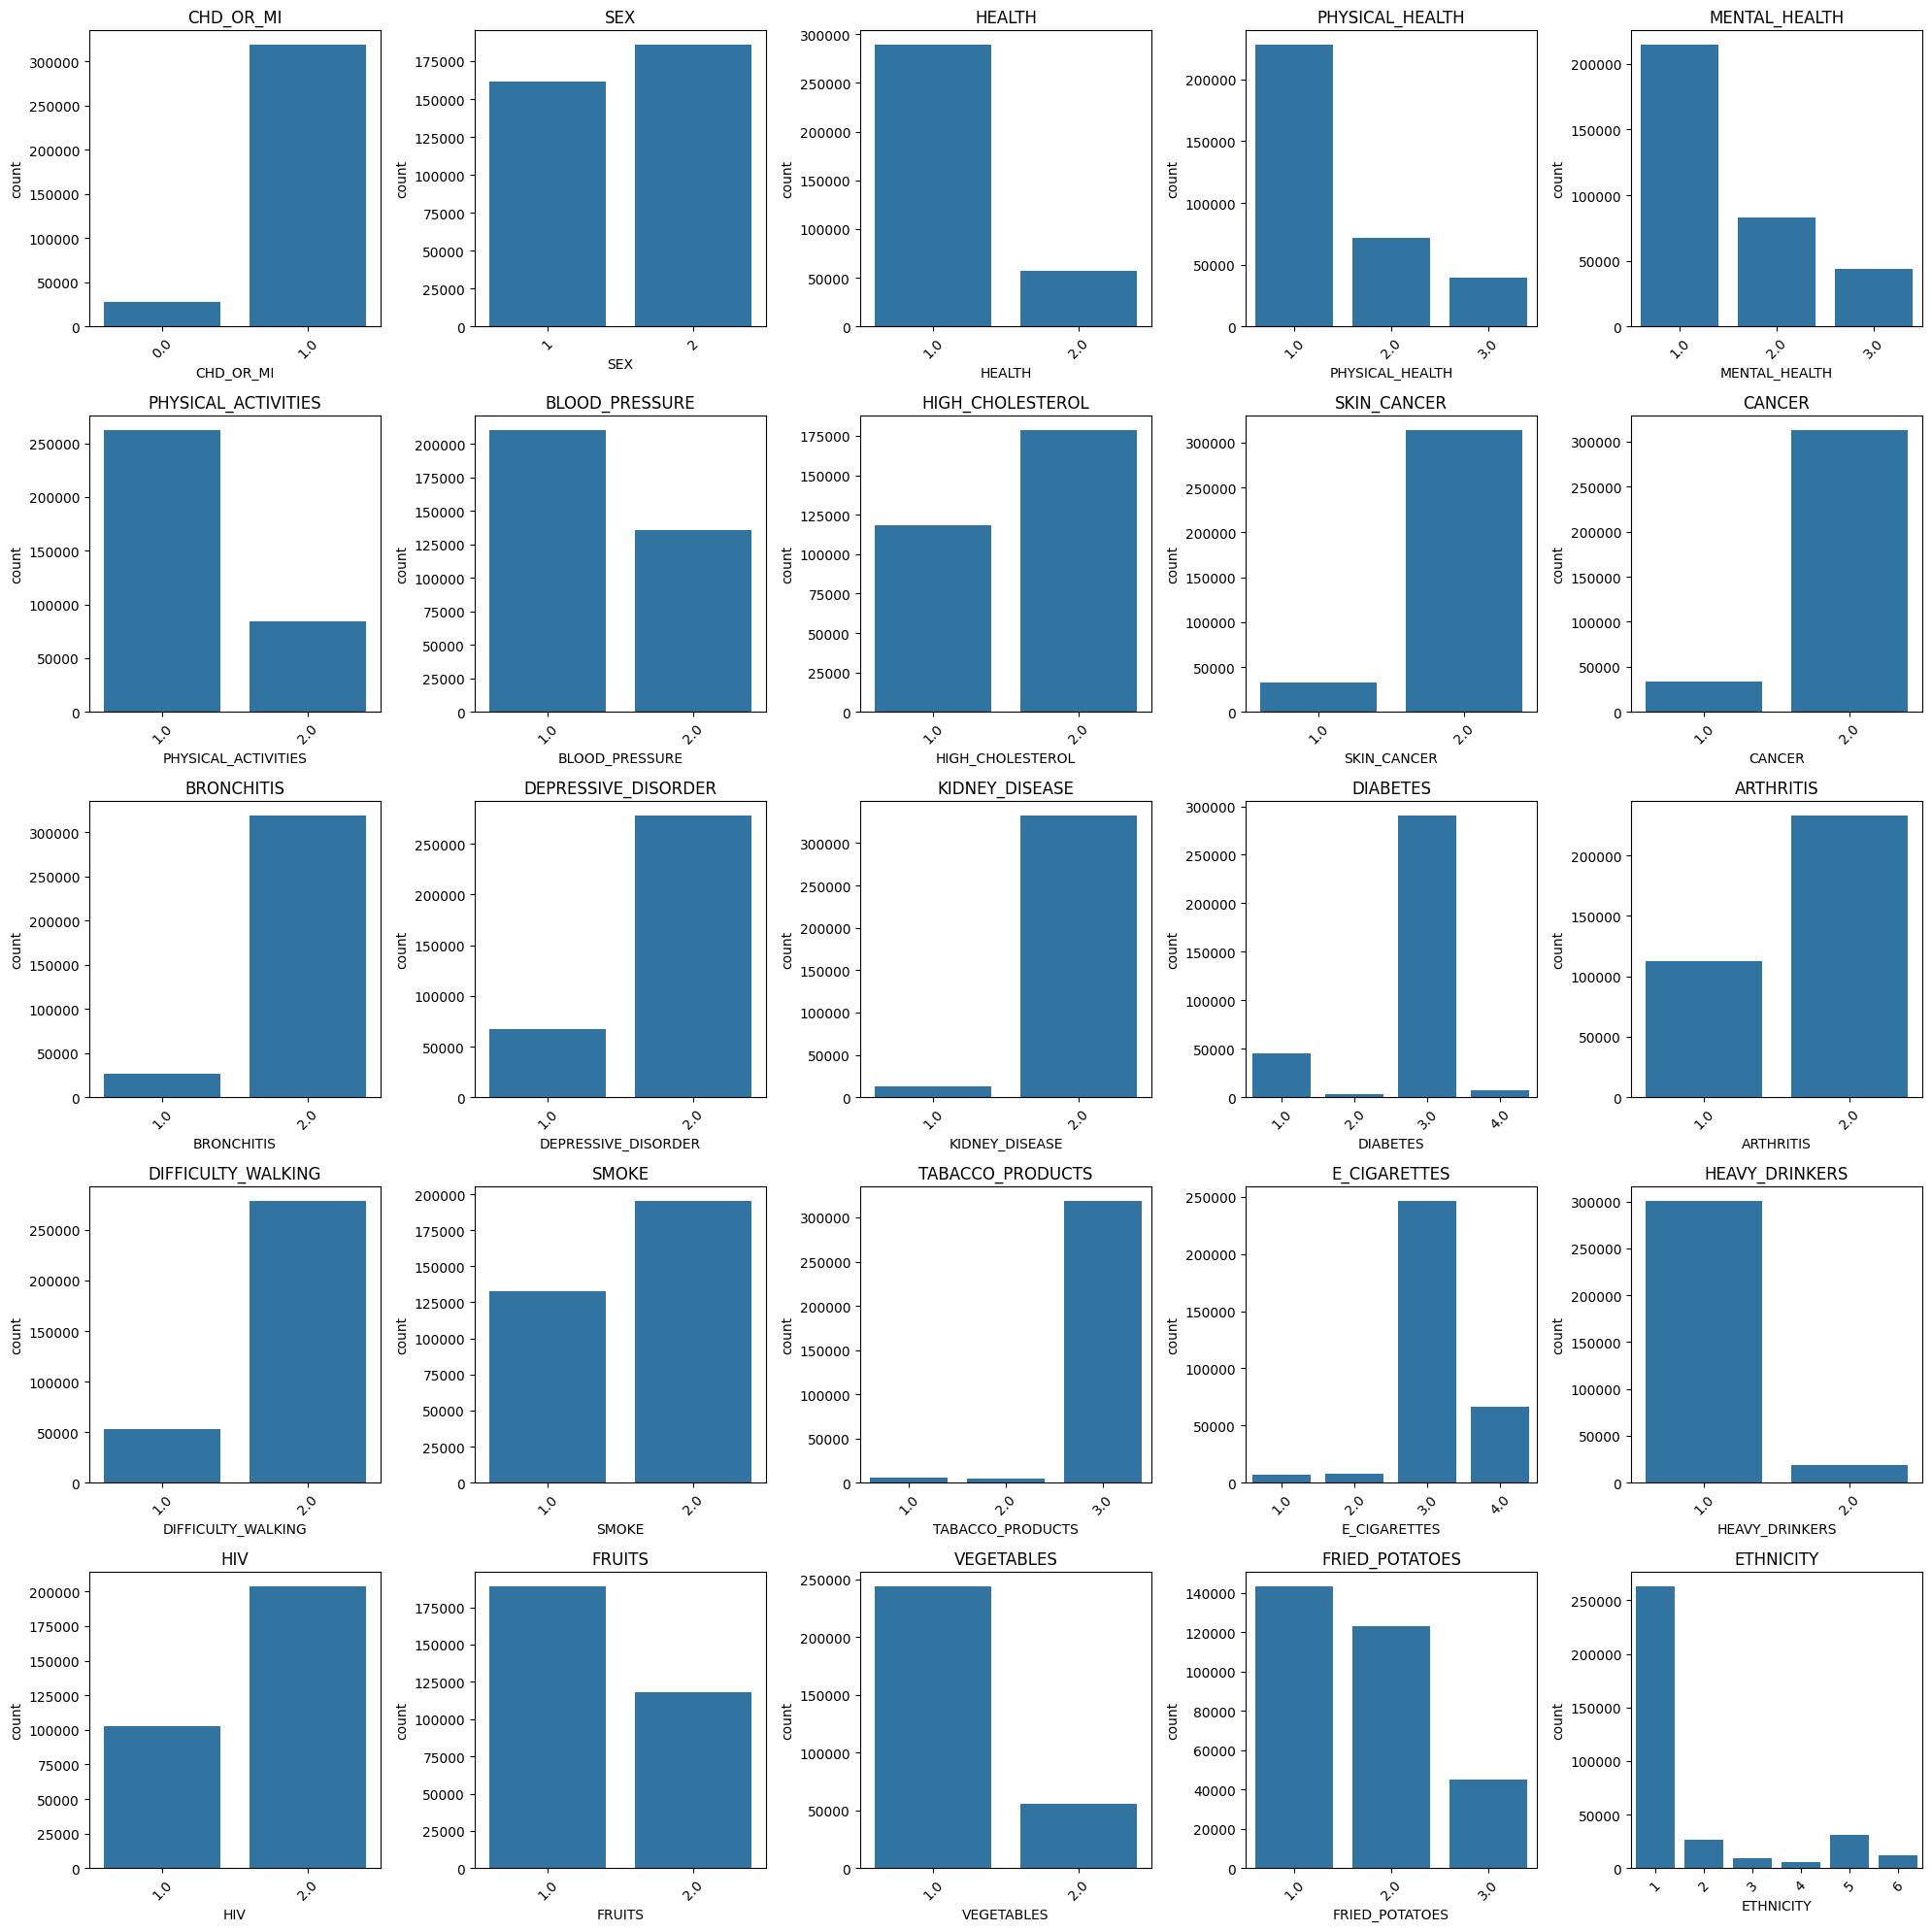

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))  # Ajustar el tamaño de la figura

# Iterar sobre las variables y los ejes
for i, col in enumerate(var_1.columns):
    row, col_idx = divmod(i, 5)  # Calcular la posición en la cuadrícula
    sns.countplot(data=var_1, x=col, ax=axes[row, col_idx])  # Crear un countplot
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].tick_params(axis='x', rotation=45)  # Rotar etiquetas si son largas

# Ocultar gráficos sobrantes si hay menos de 25 variables
for j in range(len(var_1.columns), 25):
    row, col_idx = divmod(j, 5)
    axes[row, col_idx].axis('off')

# Ajustar los espacios entre gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

Podemos categorías que tienen poca proporción de información, una de las soluciónes sería agruparlas, pero antes que nada mejor veamos su influencia con el target celdas más abajo.

#### Distribución de variables numéricas

#-------------------------#
Variable AGE
#-------------------------#


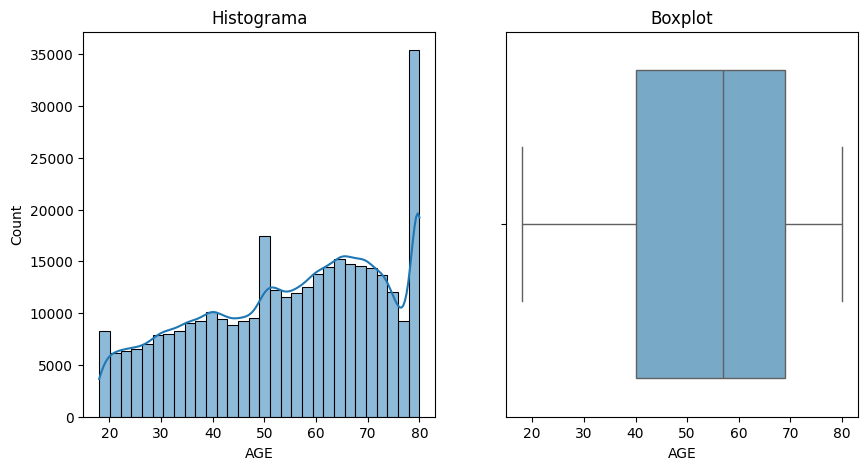

#-------------------------#
Variable BMI
#-------------------------#


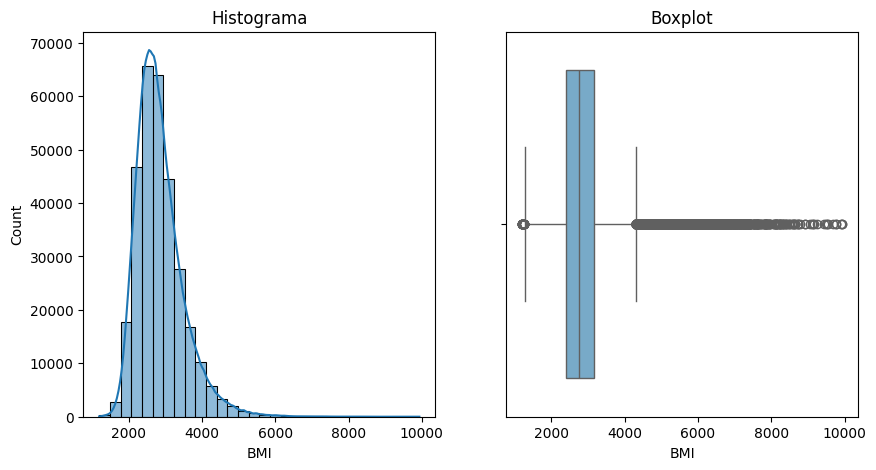

In [ ]:
var_2 = train_df[['AGE','BMI']]

for j in list(var_2):
    print('#-------------------------#')
    print('Variable',j)
    print('#-------------------------#')

    plt.figure(figsize=(10, 5))

    # Crear el subplot para el histograma
    plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
    sns.histplot(data=train_df, x=j, palette='Blues', kde=True, bins=30)
    plt.title('Histograma')

    # Crear el subplot para el boxplot
    plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
    sns.boxplot(data=train_df, x=j, palette='Blues')
    plt.title('Boxplot')
    plt.show()

**Variable EDAD:**
- El histograma muestra una gran concentración de registros en la edad de 80 años. Según la documentación, estos datos fueron imputados previamente, y la mayoría de ellos se asignaron a este valor, lo que explica la acumulación en este rango.
- Según el boxplot, la mayoría de las edades se encuentran entre los 40 y 70 años.

**Variable BMI:**
- La mayoría de los valores se concentran en un rango entre aproximadamente 2000 y 4000, lo que indica una distribución sesgada hacia la derecha (positiva) con una cola larga hacia valores más altos.
- La distribución sugiere que los valores están mayormente en el rango bajo y medio, aunque también se observan valores extremadamente altos.

**Observaciones:**
- Ambos modelos que se utilizarán, LightGBM y CatBoost, no requieren que las variables estén estandarizadas o normalizadas. Esto se debe a que estos modelos dividen los datos en función de umbrales en las variables, sin depender de las magnitudes de las características.
- Se observa que la escala del BMI está incorrecta, ya que, aunque en Estados Unidos las personas tienden a tener índices de masa corporal elevados, no es razonable que toda la población supere un BMI de 1000. Por este motivo, se decidió dividir los valores entre 100 para facilitar su interpretación.
- Aunque la gráfica muestra valores extremos de BMI, estos son posibles dada la alta prevalencia de obesidad en la población estadounidense. Podría ser útil crear categorías para representar diferentes niveles de obesidad y facilitar el análisis.


In [10]:
train_df[train_df['BMI']>7000]['BMI'].max()

9933.0

In [9]:
train_df[train_df['BMI']>7000]['BMI'].value_counts().sort_values()

,count
BMI,
8632.0,1
7033.0,1
7699.0,1
8569.0,1
7160.0,1
...,...
7318.0,3
7156.0,3
7188.0,3


#### Relación con el target

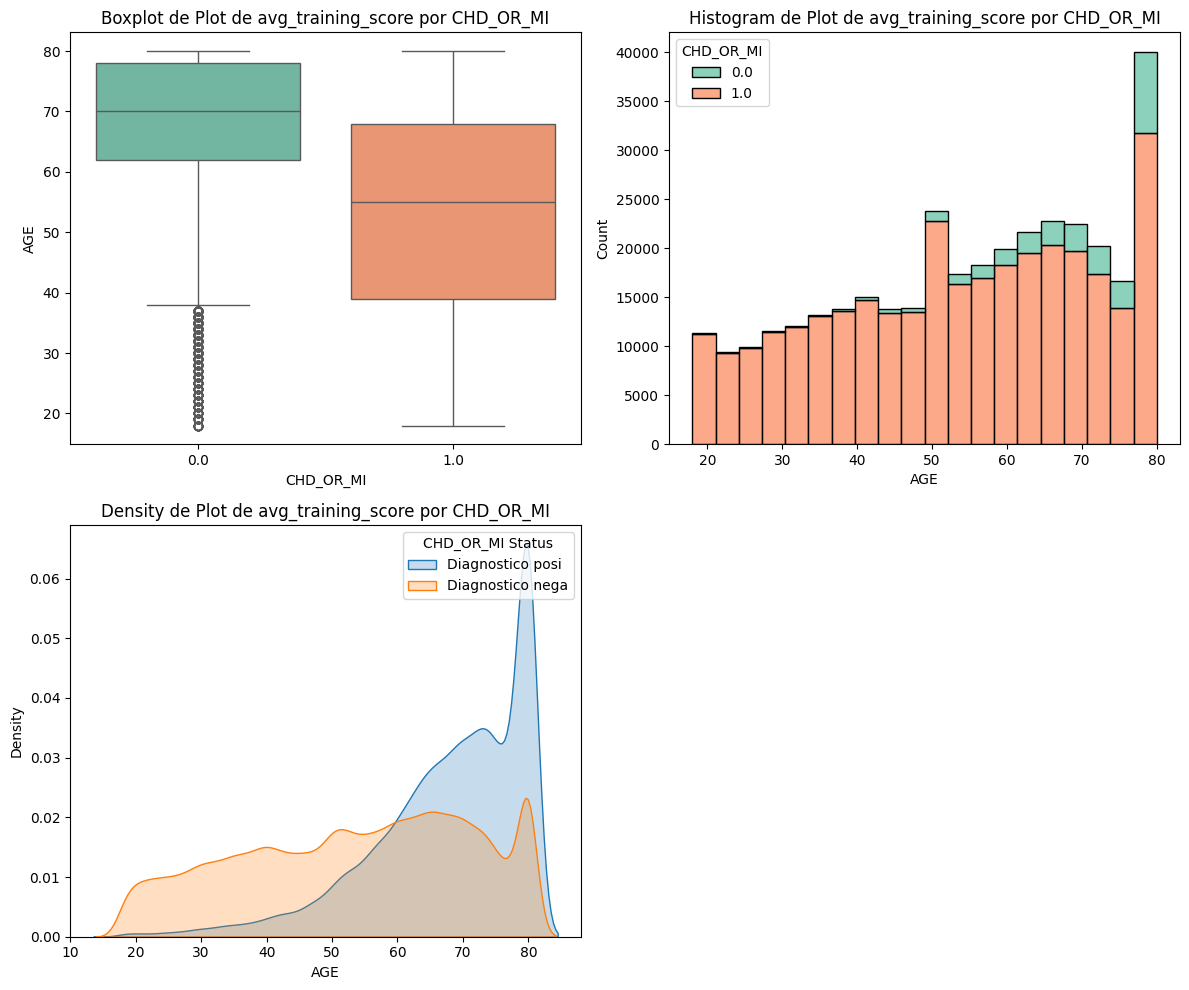

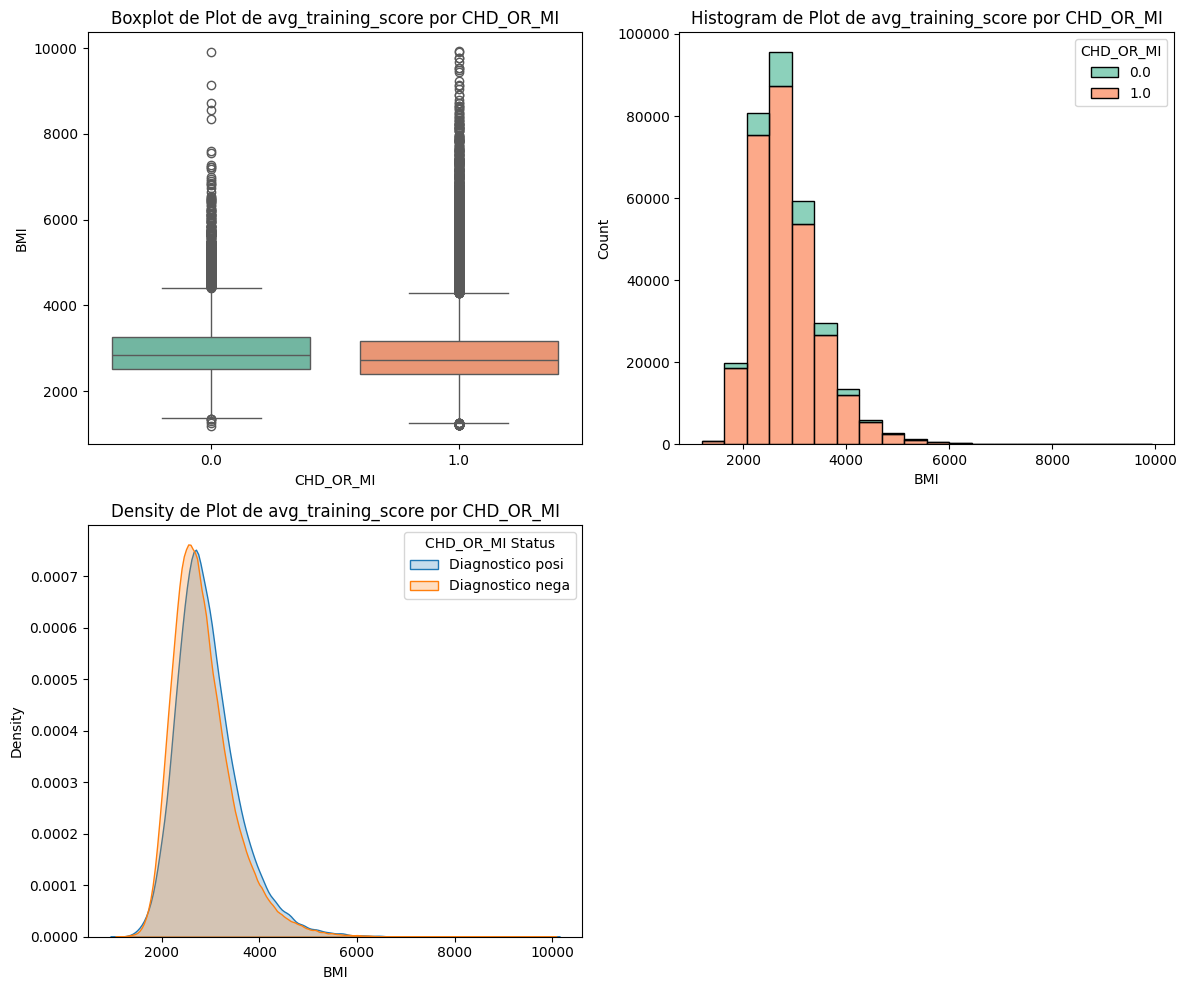

In [ ]:
for i in var_2.columns:
  data = pd.concat([train_df[i], train_df['CHD_OR_MI']], axis=1)

  # Configuración de la figura y los ejes
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Dos filas, dos columnas

  # Diagrama de caja para la variable 'avg_training_score' dividido por 'CHD_OR_MI'
  sns.boxplot(x='CHD_OR_MI', y=i, data=data, ax=axes[0, 0],palette="Set2")
  axes[0, 0].set_title('Boxplot de Plot de avg_training_score por CHD_OR_MI')
  #axes[0, 0].set_ylim(30, 110)  # Ajustar los límites del eje y

  # Histograma de 'avg_training_score' dividido por 'CHD_OR_MI'
  sns.histplot(data=data, x=i, hue='CHD_OR_MI', multiple='stack', ax=axes[0, 1], bins=20,palette="Set2")
  axes[0, 1].set_title('Histogram de Plot de avg_training_score por CHD_OR_MI')
  #axes[0, 1].set_xlim(30, 110)

  # Diagramas de densidad para cada categoría de 'CHD_OR_MI'
  sns.kdeplot(data=data[data['CHD_OR_MI'] == 0][i], shade=True, ax=axes[1, 0], label='Diagnostico posi',palette="Set2")
  sns.kdeplot(data=data[data['CHD_OR_MI'] == 1][i], shade=True, ax=axes[1, 0], label='Diagnostico nega',palette="Set2")
  axes[1, 0].set_title('Density de Plot de avg_training_score por CHD_OR_MI')
  #axes[1, 0].set_xlim(30, 110)

  # Ocultar el último panel ya que no es necesario
  axes[1, 1].set_visible(False)

  # Añadir leyendas y mejorar el layout
  axes[1, 0].legend(title='CHD_OR_MI Status')
  plt.tight_layout()
  plt.show()

**EDAD**  
- Se observa que la mayoría de los diagnósticos de enfermedad coronaria o infarto de miocardio se presentan en personas de entre 40 y 60 años (adultos). En contraste, las personas mayores de 60 años parecen ser menos propensas a ser diagnosticadas con estas condiciones. Sin embargo, es importante señalar que los resultados podrían estar sesgados debido a la alta frecuencia de imputaciones en la edad de 80 años.  
- Esta variable muestra una clara capacidad de diferenciar el target, lo que sugiere que tiene una influencia significativa en el modelo.

**BMI**  
- Aunque no se aprecia una gran diferencia entre las distribuciones, se destaca que hay más registros de personas con un índice de masa corporal (BMI) alto que han sido diagnosticadas con enfermedad coronaria o infarto de miocardio.  
- A simple vista, esta variable parece tener un impacto menos significativo en la predicción del target.

In [ ]:
for col in var_1.columns:
    if col != 'CHD_OR_MI':
        cross_tab = pd.crosstab(train_df['CHD_OR_MI'],train_df[col],margins = True,normalize = 'columns')*100
        print('#-----------------------------------------#')
        print(f"Cruce 'CHD_OR_MI' con '{col}':")
        print('#-----------------------------------------#')
        print(cross_tab.T)

#-----------------------------------------#
Cruce 'CHD_OR_MI' con 'SEX':
#-----------------------------------------#
CHD_OR_MI        0.0        1.0
SEX                            
1          10.225328  89.774672
2           6.327365  93.672635
All         8.137747  91.862253
#-----------------------------------------#
Cruce 'CHD_OR_MI' con 'HEALTH':
#-----------------------------------------#
CHD_OR_MI        0.0        1.0
HEALTH                         
1.0         5.462778  94.537222
2.0        21.657731  78.342269
All         8.122214  91.877786
#-----------------------------------------#
Cruce 'CHD_OR_MI' con 'PHYSICAL_HEALTH':
#-----------------------------------------#
CHD_OR_MI              0.0        1.0
PHYSICAL_HEALTH                      
1.0               5.769079  94.230921
2.0               8.568801  91.431199
3.0              19.765809  80.234191
All               8.002295  91.997705
#-----------------------------------------#
Cruce 'CHD_OR_MI' con 'MENTAL_HEALTH':
#--

**Conclusión general:**

Para identificar preliminarmente qué variables tienen mayor influencia en el target, se analizó cómo la distribución del target varía dentro de las diferentes categorías de cada variable.

A partir de los resultados obtenidos, se observa que las variables **"SEX, HEALTH, PHYSICAL_HEALTH, PHYSICAL_ACTIVITIES, BLOOD_PRESSURE, HIGH_CHOLESTEROL, SKIN_CANCER, CANCER, BRONCHITIS, KIDNEY_DISEASE, DIABETES, ARTHRITIS, DIFFICULTY_WALKING, SMOKE"** destacan como factores que discriminan al target, ya que presentan diferencias significativas en la distribución del target entre sus categorías.

Este análisis preliminar permite identificar las variables más relevantes para predecir el target, proporcionando una base inicial para construir y refinar los modelos predictivos.


### Imputación de valores faltantes

In [ ]:
train_df['BMI'] = train_df['BMI']/100 # Se divide el valor de BMI entre 100 como se mencionó anteriormente.

#### MISS FOREST

In [8]:
# Definimos las variables categorias, para que el modelo de imputación las pueda reconocer e imputar adecuadamente.
categorical_columns = ['SEX', 'HEALTH', 'PHYSICAL_HEALTH', 'MENTAL_HEALTH','PHYSICAL_ACTIVITIES', 'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL','SKIN_CANCER', 'CANCER', 'BRONCHITIS', 'DEPRESSIVE_DISORDER','KIDNEY_DISEASE', 'DIABETES', 'ARTHRITIS', 'DIFFICULTY_WALKING','SMOKE', 'TABACCO_PRODUCTS', 'E_CIGARETTES', 'HEAVY_DRINKERS', 'HIV','FRUITS', 'VEGETABLES', 'FRIED_POTATOES', 'ETHNICITY']
# Creamos el objeto MissForest
imputer_mixed = MissForest(categorical=categorical_columns)
# Eliminamos las variables que no usaremos para el proceso de imputación
train_df_imput = train_df.drop(columns=['CHD_OR_MI','ID'])

In [ ]:
# Ajustamos el modelo y lo guardamos en "df_mixed_imputed"
df_mixed_imputed = imputer_mixed.fit_transform(train_df_imput)

100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


In [ ]:
# Tabla imputada.
df_mixed_imputed

,SEX,AGE,HEALTH,PHYSICAL_HEALTH,MENTAL_HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,SKIN_CANCER,CANCER,...,DIFFICULTY_WALKING,SMOKE,TABACCO_PRODUCTS,E_CIGARETTES,HEAVY_DRINKERS,HIV,FRUITS,VEGETABLES,FRIED_POTATOES,ETHNICITY
0,1,34,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,...,2.0,2.0,3.0,3.0,1.0,2.0,2.0,1.0,1.0,1
1,1,76,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,...,2.0,1.0,3.0,4.0,1.0,2.0,2.0,1.0,3.0,1
2,2,69,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,3.0,3.0,1.0,2.0,2.0,1.0,2.0,2
3,2,36,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,2.0,3.0,3.0,1.0,1.0,1.0,2.0,2.0,5
4,2,21,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,...,2.0,2.0,3.0,3.0,1.0,2.0,1.0,1.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347241,1,63,1.0,3.0,2.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,3.0,3.0,1.0,2.0,1.0,1.0,2.0,6
347242,2,77,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,2.0,2.0,3.0,3.0,1.0,2.0,2.0,1.0,2.0,1
347243,1,66,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,2.0,3.0,3.0,1.0,2.0,2.0,1.0,1.0,5
347244,2,79,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,...,2.0,2.0,3.0,3.0,1.0,2.0,1.0,1.0,1.0,1


In [ ]:
df_mixed_imputed_1 = pd.concat([df_mixed_imputed,train_df[['CHD_OR_MI','ID']]],axis=1)
# Guardamos la tabla final para no tener que hacer el mismo proceso en cada momento.
df_mixed_imputed_1.to_csv('df_mixed_imputed_1.csv')

In [ ]:
df_mixed_imputed_1.shape

(347246, 28)

#### Dsitribución de las variables imputadas.

In [9]:
df_mixed_imputed_1 = pd.read_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_1.csv')
df_mixed_imputed_1.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
var_3 = df_mixed_imputed_1.drop(columns = ['AGE','BMI','ID'])
for col in var_3.columns:
    if col != 'CHD_OR_MI':
        cross_tab = pd.crosstab(df_mixed_imputed_1['CHD_OR_MI'],df_mixed_imputed_1[col],margins = True,normalize = 'columns')*100
        print('#-----------------------------------------#')
        print(f"Cruce 'CHD_OR_MI' con '{col}':")
        print('#-----------------------------------------#')
        print(cross_tab.T)

#-----------------------------------------#
Cruce 'CHD_OR_MI' con 'SEX':
#-----------------------------------------#
CHD_OR_MI        0.0        1.0
SEX                            
1          10.225328  89.774672
2           6.327365  93.672635
All         8.137747  91.862253
#-----------------------------------------#
Cruce 'CHD_OR_MI' con 'ETHNICITY':
#-----------------------------------------#
CHD_OR_MI       0.0        1.0
ETHNICITY                     
1          8.730352  91.269648
2          7.183754  92.816246
3          3.029635  96.970365
4          9.810460  90.189540
5          4.966574  95.033426
6          8.385948  91.614052
All        8.137747  91.862253
#-----------------------------------------#
Cruce 'CHD_OR_MI' con 'DIABETES':
#-----------------------------------------#
CHD_OR_MI        0.0        1.0
DIABETES                       
1.0        20.801042  79.198958
2.0         3.672131  96.327869
3.0         6.119975  93.880025
4.0        11.688144  88.311856
All    

In [ ]:
var_3.shape

(347246, 25)

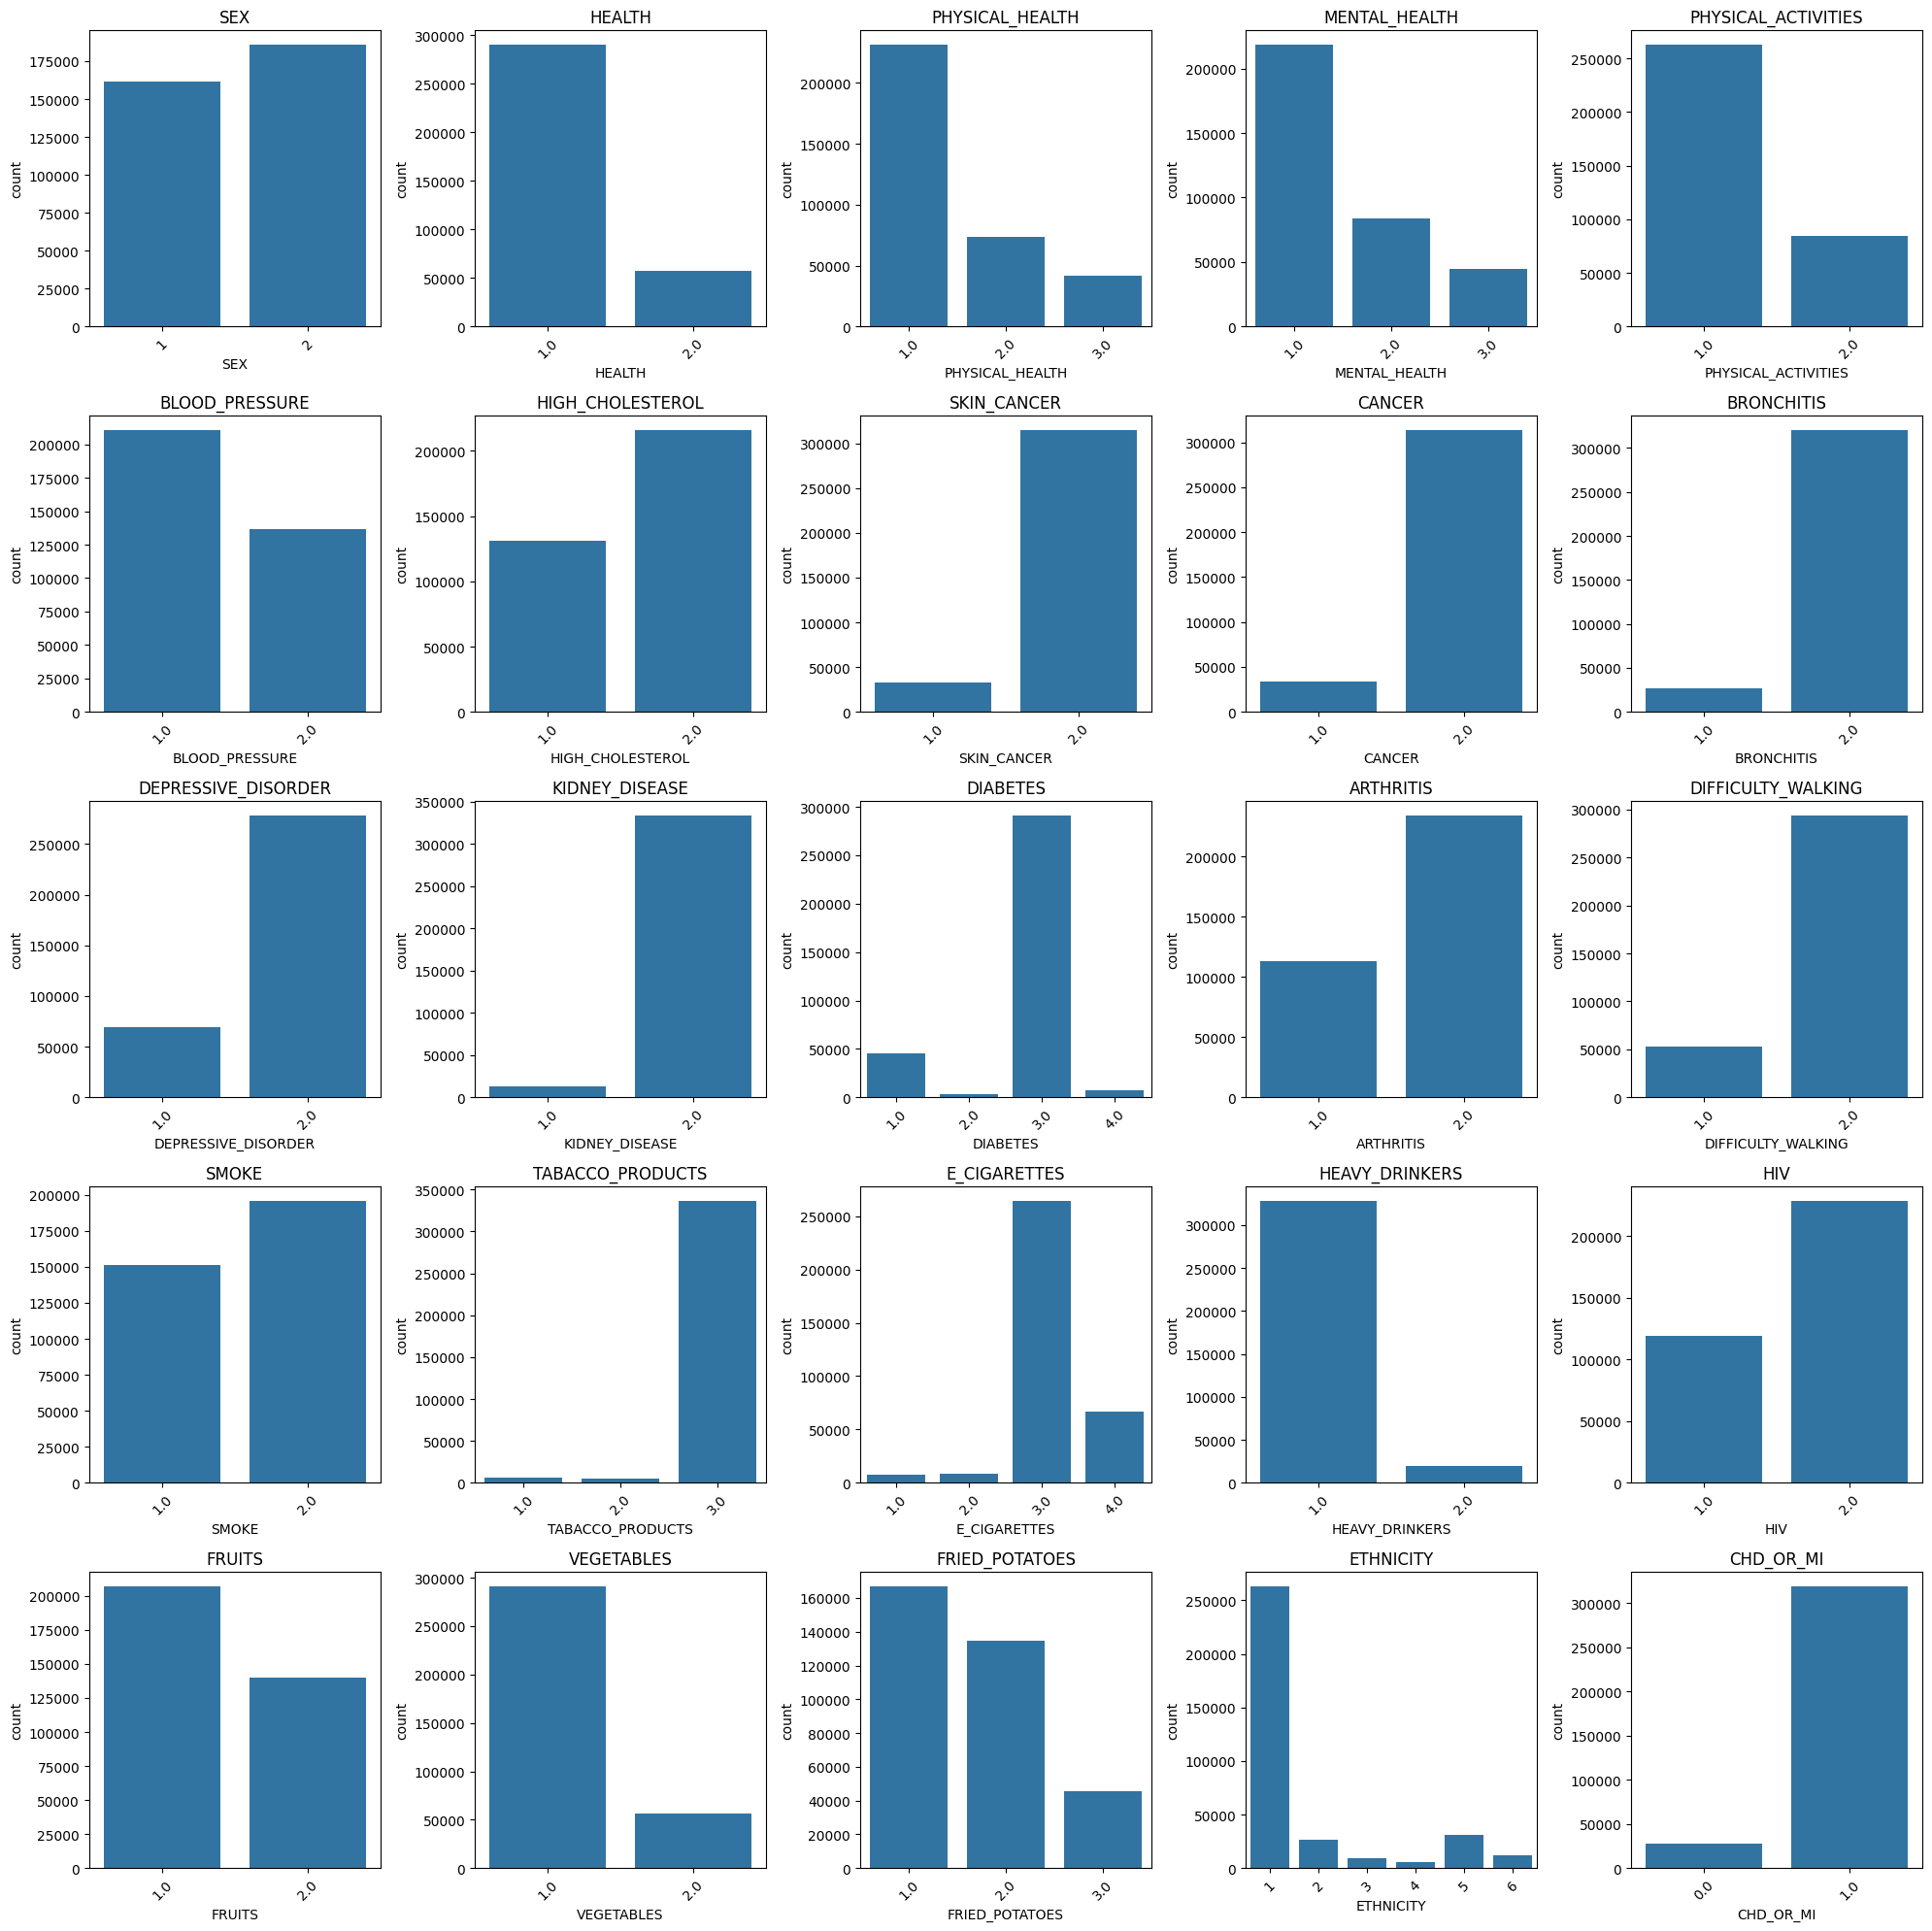

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))  # Ajustar el tamaño de la figura

# Iterar sobre las variables y los ejes
for i, col in enumerate(var_3.columns):
    row, col_idx = divmod(i, 5)  # Calcular la posición en la cuadrícula
    sns.countplot(data=var_3, x=col, ax=axes[row, col_idx])  # Crear un countplot
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].tick_params(axis='x', rotation=45)  # Rotar etiquetas si son largas

# Ocultar gráficos sobrantes si hay menos de 25 variables
for j in range(len(var_3.columns), 25):
    row, col_idx = divmod(j, 5)
    axes[row, col_idx].axis('off')

# Ajustar los espacios entre gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

#-------------------------#
Variable AGE
#-------------------------#


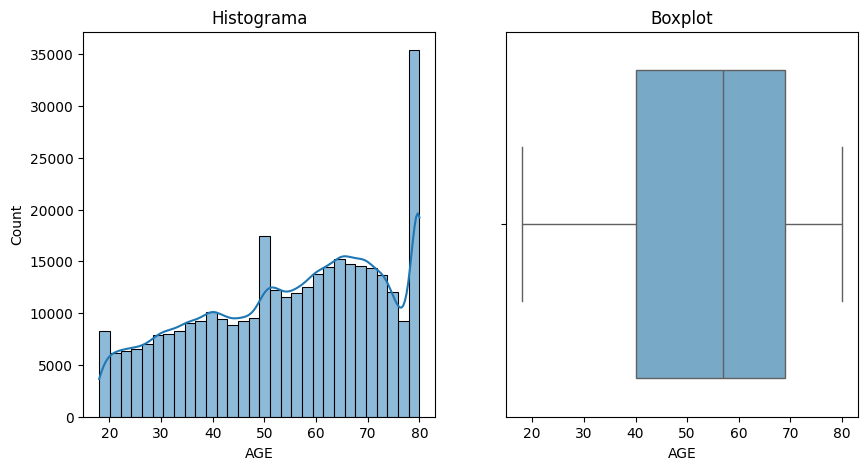

#-------------------------#
Variable BMI
#-------------------------#


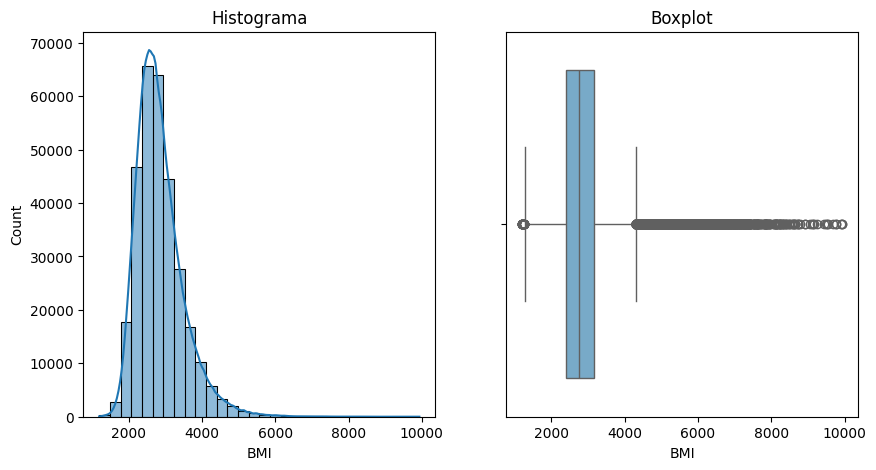

In [ ]:
var_4 = df_mixed_imputed_1[['AGE','BMI']]

for j in list(var_4):
    print('#-------------------------#')
    print('Variable',j)
    print('#-------------------------#')

    plt.figure(figsize=(10, 5))

    # Crear el subplot para el histograma
    plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
    sns.histplot(data=train_df, x=j, palette='Blues', kde=True, bins=30)
    plt.title('Histograma')

    # Crear el subplot para el boxplot
    plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
    sns.boxplot(data=train_df, x=j, palette='Blues')
    plt.title('Boxplot')
    plt.show()

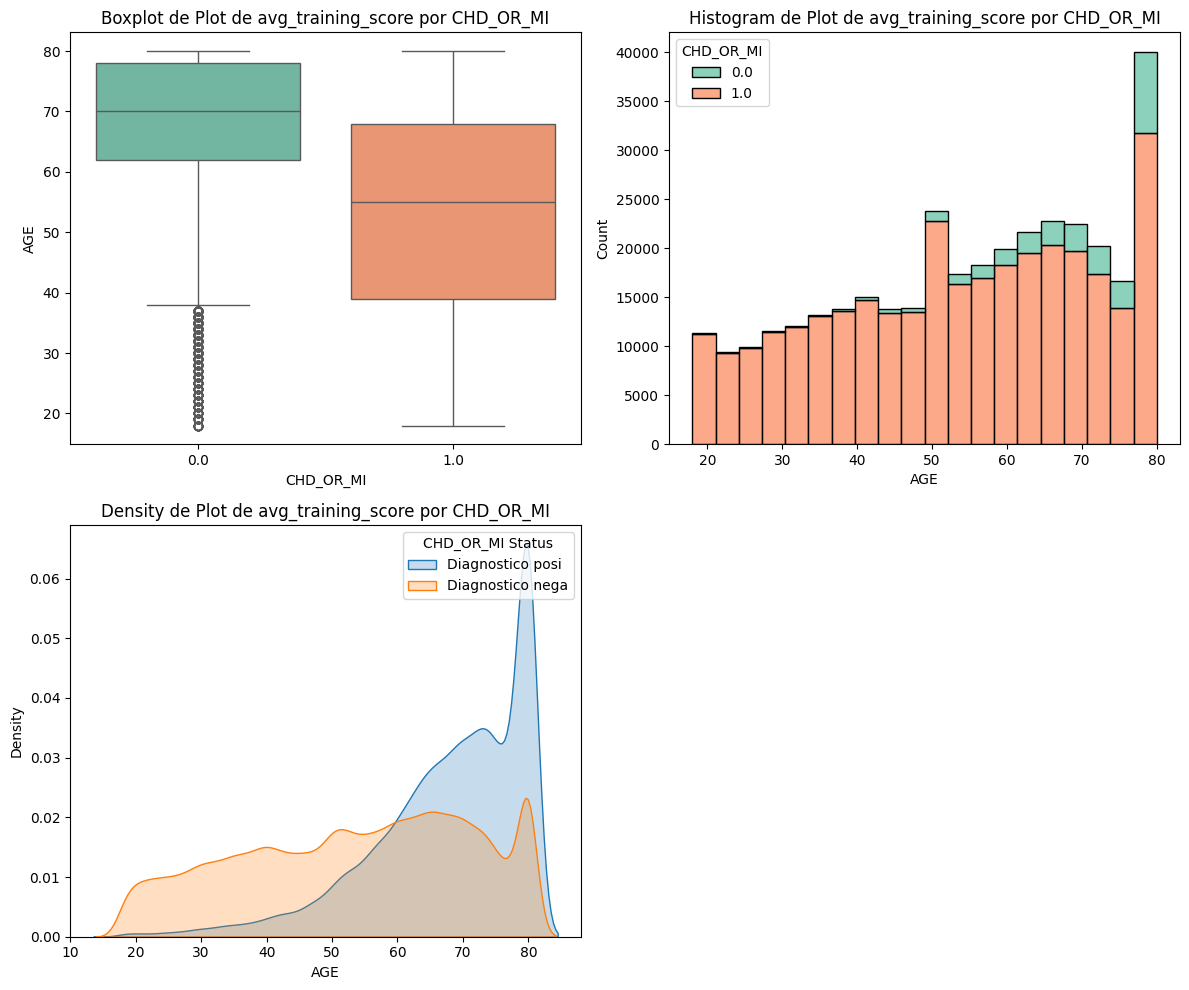

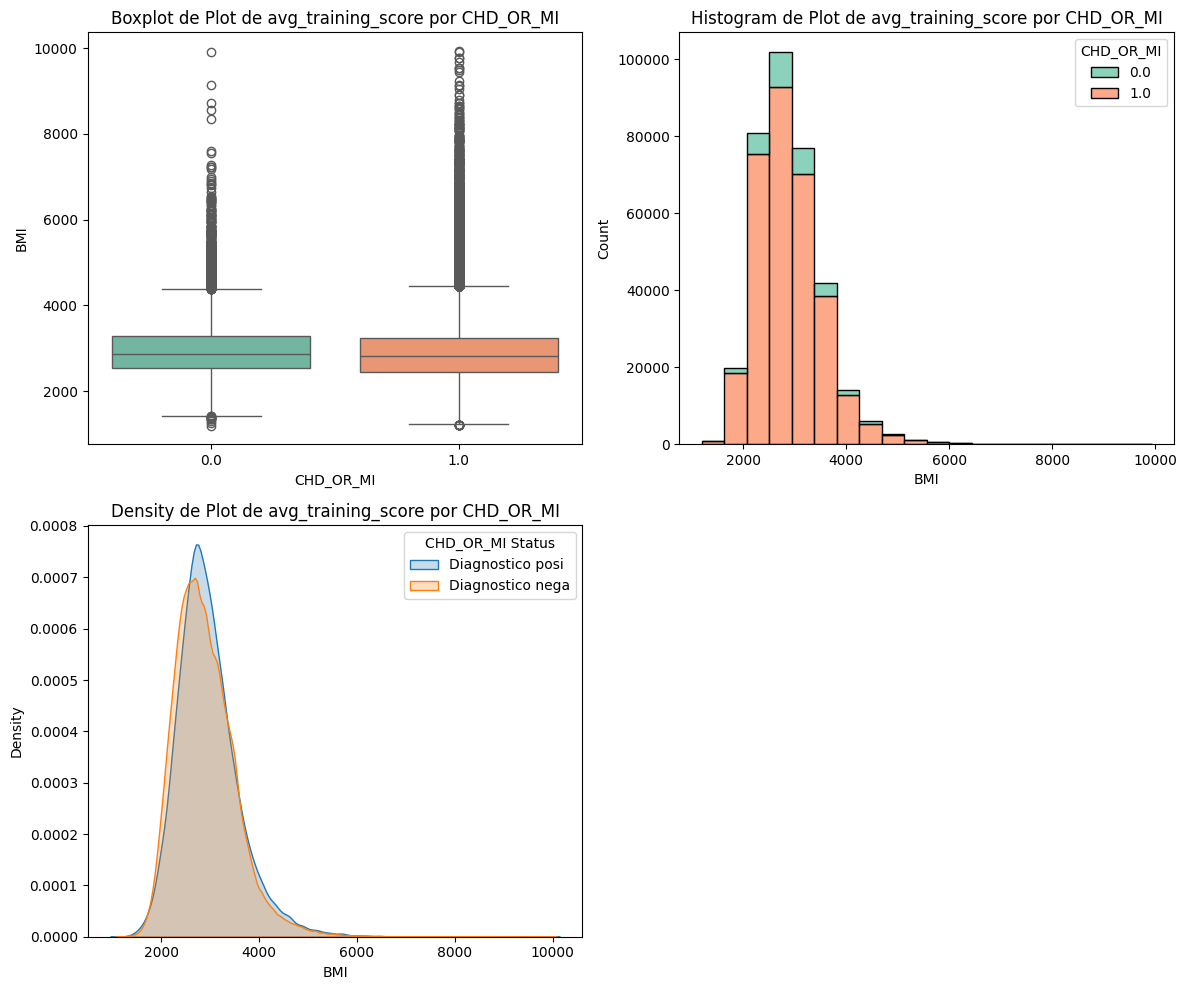

In [ ]:
for i in var_4.columns:
  data = pd.concat([df_mixed_imputed_1[i], df_mixed_imputed_1['CHD_OR_MI']], axis=1)

  # Configuración de la figura y los ejes
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Dos filas, dos columnas

  # Diagrama de caja para la variable 'avg_training_score' dividido por 'CHD_OR_MI'
  sns.boxplot(x='CHD_OR_MI', y=i, data=data, ax=axes[0, 0],palette="Set2")
  axes[0, 0].set_title('Boxplot de Plot de avg_training_score por CHD_OR_MI')
  #axes[0, 0].set_ylim(30, 110)  # Ajustar los límites del eje y

  # Histograma de 'avg_training_score' dividido por 'CHD_OR_MI'
  sns.histplot(data=data, x=i, hue='CHD_OR_MI', multiple='stack', ax=axes[0, 1], bins=20,palette="Set2")
  axes[0, 1].set_title('Histogram de Plot de avg_training_score por CHD_OR_MI')
  #axes[0, 1].set_xlim(30, 110)

  # Diagramas de densidad para cada categoría de 'CHD_OR_MI'
  sns.kdeplot(data=data[data['CHD_OR_MI'] == 0][i], shade=True, ax=axes[1, 0], label='Diagnostico posi',palette="Set2")
  sns.kdeplot(data=data[data['CHD_OR_MI'] == 1][i], shade=True, ax=axes[1, 0], label='Diagnostico nega',palette="Set2")
  axes[1, 0].set_title('Density de Plot de avg_training_score por CHD_OR_MI')
  #axes[1, 0].set_xlim(30, 110)

  # Ocultar el último panel ya que no es necesario
  axes[1, 1].set_visible(False)

  # Añadir leyendas y mejorar el layout
  axes[1, 0].legend(title='CHD_OR_MI Status')
  plt.tight_layout()
  plt.show()

**Variables Categóricas**
- Al analizar las variables categóricas tanto numérica como gráficamente, se observa que la distribución de las categorías no ha experimentado cambios significativos. De hecho, se puede afirmar que las distribuciones son prácticamente iguales.

**Variables Numéricas**
- La única variable imputada fue BMI. En términos generales, su distribución parece mantenerse, aunque al separar los datos según el target, se notan algunas variaciones.


### Modelado

MODELO CATBOOST

In [10]:
# Para que el modelo catboost necesitamos que las variables categoricas sean tipo object
df_mixed_imputed_1[categorical_columns] = df_mixed_imputed_1[categorical_columns].astype(str)

In [11]:
# Dividir los datos con estratificación
X = df_mixed_imputed_1.drop(columns=['ID', 'CHD_OR_MI'])
y = df_mixed_imputed_1['CHD_OR_MI']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [ ]:
# Definir el modelo base
model_catboost_grid = CatBoostClassifier(
    iterations=1000,
    cat_features=categorical_columns,
    verbose=100
)

# Definir los hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 5]
}


# Cambiar la métrica a F1-score
f1_scorer = make_scorer(f1_score)

# Configurar GridSearchCV
grid_search_catboost = GridSearchCV(
    estimator=model_catboost_grid,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,  # Número de folds para la validación cruzada
    verbose=2,
    n_jobs=4
)

# Entrenar el modelo con búsqueda en cuadrícula
grid_search_catboost.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
0:	learn: 0.6791638	total: 153ms	remaining: 2m 32s
100:	learn: 0.2572279	total: 7.79s	remaining: 1m 9s
200:	learn: 0.2250408	total: 13.9s	remaining: 55.3s
300:	learn: 0.2194863	total: 20.9s	remaining: 48.6s
400:	learn: 0.2179171	total: 27.4s	remaining: 41s
500:	learn: 0.2171283	total: 34.4s	remaining: 34.3s
600:	learn: 0.2166552	total: 40.8s	remaining: 27.1s
700:	learn: 0.2163385	total: 47.4s	remaining: 20.2s
800:	learn: 0.2160610	total: 53.6s	remaining: 13.3s
900:	learn: 0.2158719	total: 59.9s	remaining: 6.58s
999:	learn: 0.2156985	total: 1m 5s	remaining: 0us


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fb5f1d8d420>,
             n_jobs=4,
             param_grid={'depth': [4, 6], 'iterations': [500, 1000],
                         'l2_leaf_reg': [1, 5], 'learning_rate': [0.01, 0.1]},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

In [ ]:
grid_search_catboost.best_params_

{'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 5, 'learning_rate': 0.01}

In [12]:
grid_search_catboost = CatBoostClassifier(
    iterations=1000,
    cat_features=categorical_columns,
    verbose=100,
    depth = 6,
    l2_leaf_reg = 5,
    learning_rate =  0.01
)
grid_search_catboost.fit(X_train, y_train)

0:	learn: 0.6787924	total: 469ms	remaining: 7m 48s
100:	learn: 0.2565028	total: 42.1s	remaining: 6m 14s
200:	learn: 0.2245822	total: 1m 18s	remaining: 5m 12s
300:	learn: 0.2193002	total: 2m 3s	remaining: 4m 46s
400:	learn: 0.2176709	total: 2m 51s	remaining: 4m 16s
500:	learn: 0.2169174	total: 3m 44s	remaining: 3m 43s
600:	learn: 0.2164482	total: 4m 22s	remaining: 2m 54s
700:	learn: 0.2161699	total: 4m 56s	remaining: 2m 6s
800:	learn: 0.2159426	total: 5m 32s	remaining: 1m 22s
900:	learn: 0.2157286	total: 6m 7s	remaining: 40.4s
999:	learn: 0.2155496	total: 6m 42s	remaining: 0us


In [13]:
print("\nResultados del Modelo con Catboost data train:")
y_pred_train_catboost = grid_search_catboost.predict(X_train)
y_pred_proba_train_catboost = grid_search_catboost.predict_proba(X_train)[:, 1]


# Cálculo de métricas
cm_catboost_train = confusion_matrix(y_train, y_pred_train_catboost)
sensitivity_catboost_train = recall_score(y_train, y_pred_train_catboost)
specificity_catboost_train = cm_catboost_train[0, 0] / sum(cm_catboost_train[0, :])
accuracy_catboost_train = accuracy_score(y_train, y_pred_train_catboost)
balanced_accuracy_catboost_train = (sensitivity_catboost_train + specificity_catboost_train) / 2
logloss_catboost_train = log_loss(y_train, y_pred_proba_train_catboost)
f1score_catboost_train = f1_score(y_train, y_pred_train_catboost)  # Cálculo del F1-score
precision_catboost_train = cm_catboost_train[1, 1] / (cm_catboost_train[1, 1] + cm_catboost_train[0, 1])
average_precision_catboost_train = average_precision_score(y_train, y_pred_proba_train_catboost)
roc_auc = roc_auc_score(y_train, y_pred_proba_train_catboost)

# Mostrar métricas
print("Matriz de Confusión (train): \n", cm_catboost_train)
print(f"Sensibilidad (train) : {sensitivity_catboost_train:.4f}")
print(f"Especificidad (train): {specificity_catboost_train:.4f}")
print(f"Accuracy (train): {accuracy_catboost_train:.4f}")
print(f"Balanced Accuracy (train): {balanced_accuracy_catboost_train:.4f}")
print(f"Log-Loss (train): {logloss_catboost_train:.4f}")
print(f"f1score (train): {f1score_catboost_train:.4f}")
print(f"Precisión (train): {precision_catboost_train:.4f}")
print(f"Average Precision (AP) (train): {average_precision_catboost_train:.4f}")
print(f"ROC-AUC: {roc_auc}")


Resultados del Modelo con Catboost data train:
Matriz de Confusión (train): 
 [[  1238  18543]
 [   789 222502]]
Sensibilidad (train) : 0.9965
Especificidad (train): 0.0626
Accuracy (train): 0.9205
Balanced Accuracy (train): 0.5295
Log-Loss (train): 0.2157
f1score (train): 0.9584
Precisión (train): 0.9231
Average Precision (AP) (train): 0.9831
ROC-AUC: 0.8483735567916836


In [15]:
print("\nResultados del Modelo con Catboost en la data testing:")
y_pred_test_catboost = grid_search_catboost.predict(X_test)
y_pred_proba_test_catboost = grid_search_catboost.predict_proba(X_test)[:, 1]


# Cálculo de métricas
cm_catboost_test = confusion_matrix(y_test, y_pred_test_catboost)
sensitivity_catboost_test = recall_score(y_test, y_pred_test_catboost)
specificity_catboost_test = cm_catboost_test[0, 0] / sum(cm_catboost_test[0, :])
accuracy_catboost_test = accuracy_score(y_test, y_pred_test_catboost)
balanced_accuracy_catboost_test = (sensitivity_catboost_test + specificity_catboost_test) / 2
logloss_catboost_test = log_loss(y_test, y_pred_proba_test_catboost)
f1score_catboost_test = f1_score(y_test, y_pred_test_catboost)  # Cálculo del F1-score
precision_catboost_test = cm_catboost_test[1, 1] / (cm_catboost_test[1, 1] + cm_catboost_test[0, 1])
average_precision_catboost_test = average_precision_score(y_test, y_pred_proba_test_catboost)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test_catboost)

# Mostrar métricas
print("Matriz de Confusión (test):\n", cm_catboost_test)
print(f"Sensibilidad (test): {sensitivity_catboost_test:.4f}")
print(f"Especificidad (test): {specificity_catboost_test:.4f}")
print(f"Accuracy (test): {accuracy_catboost_test:.4f}")
print(f"Balanced Accuracy (test): {balanced_accuracy_catboost_test:.4f}")
print(f"Log-Loss (test): {logloss_catboost_test:.4f}")
print(f"f1score (test): {f1score_catboost_test:.4f}")
print(f"Precisión (test): {precision_catboost_test:.4f}")
print(f"Average Precision (AP) (test): {average_precision_catboost_test:.4f}")
print(f"ROC-AUC: {roc_auc_test}")


Resultados del Modelo con Catboost en la data testing:
Matriz de Confusión (test):
 [[  466  8011]
 [  348 95349]]
Sensibilidad (test): 0.9964
Especificidad (test): 0.0550
Accuracy (test): 0.9198
Balanced Accuracy (test): 0.5257
Log-Loss (test): 0.2146
f1score (test): 0.9580
Precisión (test): 0.9225
Average Precision (AP) (test): 0.9837
ROC-AUC: 0.8514171968562709


In [54]:
metrics_data = {
    "Métrica": [
        "Sensibilidad", "Especificidad", "Accuracy", "Balanced Accuracy",
        "Log-Loss", "f1score", "Precisión", "Average Precision (AP)",'ROC-AUC'
    ],
    "Entrenamiento": [
        sensitivity_catboost_train, specificity_catboost_train, accuracy_catboost_train,
        balanced_accuracy_catboost_train, logloss_catboost_train, f1score_catboost_train,
        precision_catboost_train, average_precision_catboost_train,roc_auc
    ],
    "Prueba": [
        sensitivity_catboost_test, specificity_catboost_test, accuracy_catboost_test,
        balanced_accuracy_catboost_test, logloss_catboost_test, f1score_catboost_test,
        precision_catboost_test, average_precision_catboost_test,roc_auc_test
    ]
}

metrics_df = pd.DataFrame(metrics_data)

metrics_df

,Métrica,Entrenamiento,Prueba
0,Sensibilidad,0.996466,0.996063
1,Especificidad,0.062585,0.059740
2,Accuracy,0.920468,0.919873
3,Balanced Accuracy,0.529526,0.527901
4,Log-Loss,0.215701,0.219271
5,f1score,0.958366,0.958052
6,Precisión,0.923072,0.922836
7,Average Precision (AP),0.983074,0.982113
8,ROC-AUC,0.848374,0.841121


El modelo CatBoost, aunque es robusto frente al desbalance de clases, es muy bueno para detectar casos positivos, con un F1-score de 0.958 tanto en los datos de entrenamiento como en los de prueba. Esto indica que es efectivo para identificar correctamente a las personas con enfermedad coronaria. Sin embargo, a pesar de su capacidad para manejar datos desbalanceados, tiene un problema: tiende a clasificar muchos casos sanos como enfermos, lo que hace que su capacidad para distinguir correctamente entre personas enfermas y sanas (Balanced Accuracy) no sea tan alta. En resumen, el modelo es excelente para encontrar a los enfermos, pero no es tan preciso para diferenciar entre ambos grupos, lo cual es importante en situaciones donde los falsos diagnósticos puedan ser problemáticos, como en el diagnóstico de enfermedades coronarias.

               Feature  Importance
2                  AGE   36.461769
25    HIGH_CHOLESTEROL   11.283950
9       BLOOD_PRESSURE   10.476563
6               HEALTH    8.528304
0                  SEX    8.034906
3             DIABETES    3.572172
18               SMOKE    3.541471
15  DIFFICULTY_WALKING    3.308198
10          BRONCHITIS    3.171969
14     PHYSICAL_HEALTH    2.477385


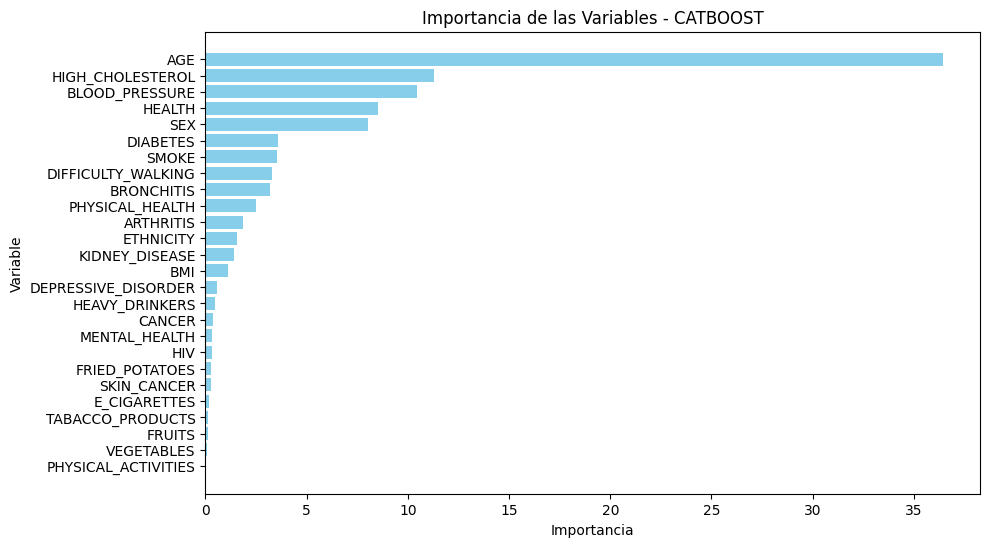

In [23]:
# Obtener la importancia de las variables
feature_importances = grid_search_catboost.feature_importances_

feature_names = X_train.columns  # Asegúrate de que X_train es un DataFrame con nombres de columnas

# Crear un DataFrame para visualizar mejor
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las primeras variables más importantes
print(importance_df.head(10))

# Visualizar las importancias
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invertir el eje Y para que las más importantes estén arriba
plt.title('Importancia de las Variables - CATBOOST')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

Como se mencionó en el análisis preliminar, las variables más relevantes en este modelo son la edad, "SEX, HEALTH, PHYSICAL_HEALTH, PHYSICAL_ACTIVITIES, BLOOD_PRESSURE, HIGH_CHOLESTEROL, SKIN_CANCER, CANCER, BRONCHITIS, KIDNEY_DISEASE, DIABETES, ARTHRITIS, DIFFICULTY_WALKING, SMOKE".

El gráfico confirma que las enfermedades coronarias están principalmente determinadas por factores como la edad, el colesterol alto y la presión arterial. Sin embargo, también se destacan otros factores médicos y de estilo de vida que juegan un papel significativo, lo que sugiere la necesidad de adoptar un enfoque multifactorial en el análisis y la prevención de estas enfermedades.

**AHORA REPETIREMOS EL MISMO ANÁLISIS EN LA DATA TEST PRIVATE Y PUBLIC**

# TEST

In [26]:
test_df_public

,CHD_OR_MI,SEX,AGE,HEALTH,PHYSICAL_HEALTH,MENTAL_HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,SKIN_CANCER,...,SMOKE,TABACCO_PRODUCTS,E_CIGARETTES,HEAVY_DRINKERS,HIV,FRUITS,VEGETABLES,FRIED_POTATOES,ETHNICITY,ID
0,1.0,2,70,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,3.0,3.0,1.0,2.0,1.0,1.0,2.0,1,PID2022_100531
1,1.0,1,32,1.0,3.0,2.0,1.0,1.0,2.0,2.0,...,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1,PID2022_043184
2,1.0,1,69,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,3.0,4.0,1.0,2.0,1.0,2.0,1.0,1,PID2022_071971
3,1.0,1,36,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,2.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,2,PID2022_070778
4,1.0,1,63,1.0,2.0,1.0,1.0,2.0,1.0,2.0,...,2.0,3.0,4.0,1.0,2.0,1.0,1.0,1.0,1,PID2022_082363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,0.0,1,69,2.0,1.0,3.0,1.0,2.0,1.0,2.0,...,2.0,3.0,3.0,1.0,1.0,2.0,1.0,1.0,6,PID2022_256399
43402,1.0,2,57,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PID2022_326390
43403,0.0,1,75,1.0,1.0,1.0,1.0,2.0,1.0,2.0,...,2.0,3.0,3.0,1.0,2.0,1.0,1.0,1.0,5,PID2022_178405
43404,1.0,2,50,1.0,2.0,1.0,2.0,1.0,2.0,1.0,...,1.0,3.0,3.0,1.0,1.0,2.0,2.0,2.0,1,PID2022_220522


In [ ]:
info_data = {
    'Tipo de Dato': train_df.dtypes,
    'Valores Nulos': train_df.isnull().sum(),
    'Valores unicos': train_df.nunique(),
    '% Valores Nulos': np.round(train_df.isnull().sum()/train_df.shape[0]*100,2),
    'Valores No Nulos': train_df.notnull().sum()
}

# Creando el DataFrame
estructura_datos = pd.DataFrame(info_data)
estructura_datos.sort_values('% Valores Nulos', ascending=False)

,Tipo de Dato,Valores Nulos,Valores unicos,% Valores Nulos,Valores No Nulos
HIGH_CHOLESTEROL,float64,50191,2,14.45,297055
VEGETABLES,float64,47387,2,13.65,299859
HIV,float64,40794,2,11.75,306452
FRUITS,float64,40254,2,11.59,306992
BMI,float64,36960,3702,10.64,310286
FRIED_POTATOES,float64,35302,3,10.17,311944
HEAVY_DRINKERS,float64,27583,2,7.94,319663
SMOKE,float64,19263,2,5.55,327983
E_CIGARETTES,float64,18884,4,5.44,328362
TABACCO_PRODUCTS,float64,18033,3,5.19,329213


In [ ]:
test_df_public_1 = test_df_public.drop(columns = ['CHD_OR_MI','ID'])

In [ ]:
df_mixed_imputed_public = imputer_mixed.fit_transform(test_df_public_1)

 60%|██████    | 3/5 [00:01<00:01,  1.88it/s]


In [ ]:
df_mixed_imputed_public_1 = pd.concat([df_mixed_imputed_public,test_df_public[['CHD_OR_MI','ID']]],axis=1)

In [43]:
df_mixed_imputed_public_1 = pd.read_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_public.csv')

In [44]:
df_mixed_imputed_public_1.drop(columns=['Unnamed: 0'],inplace=True)

In [45]:
df_mixed_imputed_public_1.shape

(43406, 28)

In [46]:
df_mixed_imputed_public_1[categorical_columns] = df_mixed_imputed_public_1[categorical_columns].astype(str)

In [47]:
X_test = df_mixed_imputed_public_1.drop(columns = ['CHD_OR_MI','ID'])
y_test = df_mixed_imputed_public_1['CHD_OR_MI']

In [48]:
print("\nResultados del Modelo con Catboost en la data TEST PUBLIC:")
y_pred_test_catboost = grid_search_catboost.predict(X_test)
y_pred_proba_test_catboost = grid_search_catboost.predict_proba(X_test)[:, 1]


# Cálculo de métricas
cm_catboost_test = confusion_matrix(y_test, y_pred_test_catboost)
sensitivity_catboost_test = recall_score(y_test, y_pred_test_catboost)
specificity_catboost_test = cm_catboost_test[0, 0] / sum(cm_catboost_test[0, :])
accuracy_catboost_test = accuracy_score(y_test, y_pred_test_catboost)
balanced_accuracy_catboost_test = (sensitivity_catboost_test + specificity_catboost_test) / 2
logloss_catboost_test = log_loss(y_test, y_pred_proba_test_catboost)
f1score_catboost_test = f1_score(y_test, y_pred_test_catboost)  # Cálculo del F1-score
precision_catboost_test = cm_catboost_test[1, 1] / (cm_catboost_test[1, 1] + cm_catboost_test[0, 1])
average_precision_catboost_test = average_precision_score(y_test, y_pred_proba_test_catboost)


# Mostrar métricas
print("Matriz de Confusión (test):\n", cm_catboost_test)
print(f"Sensibilidad (test): {sensitivity_catboost_test:.4f}")
print(f"Especificidad (test): {specificity_catboost_test:.4f}")
print(f"Accuracy (test): {accuracy_catboost_test:.4f}")
print(f"Balanced Accuracy (test): {balanced_accuracy_catboost_test:.4f}")
print(f"Log-Loss (test): {logloss_catboost_test:.4f}")
print(f"f1score (test): {f1score_catboost_test:.4f}")
print(f"Precisión (test): {precision_catboost_test:.4f}")
print(f"Average Precision (AP) (test): {average_precision_catboost_test:.4f}")


Resultados del Modelo con Catboost en la data TEST PUBLIC:
Matriz de Confusión (test):
 [[  211  3321]
 [  157 39717]]
Sensibilidad (test): 0.9961
Especificidad (test): 0.0597
Accuracy (test): 0.9199
Balanced Accuracy (test): 0.5279
Log-Loss (test): 0.2193
f1score (test): 0.9581
Precisión (test): 0.9228
Average Precision (AP) (test): 0.9821


In [ ]:
df_mixed_imputed_public_1['Predicciones_catboos_public'] = y_pred_test_catboost
df_mixed_imputed_public_1['Predicciones_proba_catboos_public'] = y_pred_proba_test_catboost
df_mixed_imputed_public_1

,SEX,ETHNICITY,AGE,DIABETES,PHYSICAL_ACTIVITIES,CANCER,SKIN_CANCER,HEALTH,KIDNEY_DISEASE,BLOOD_PRESSURE,...,FRIED_POTATOES,BMI,FRUITS,HIV,VEGETABLES,HIGH_CHOLESTEROL,CHD_OR_MI,ID,Predicciones_catboos_public,Predicciones_proba_catboos_public
0,2,1,70,3.0,1.0,2.0,1.0,1.0,2.0,2.0,...,2.0,2130.000000,1.0,2.0,1.0,1.0,1.0,PID2022_100531,1.0,0.919020
1,1,1,32,3.0,1.0,2.0,2.0,1.0,2.0,1.0,...,1.0,2439.000000,1.0,1.0,1.0,2.0,1.0,PID2022_043184,1.0,0.982532
2,1,1,69,1.0,1.0,2.0,2.0,1.0,2.0,2.0,...,1.0,3138.000000,1.0,2.0,2.0,2.0,1.0,PID2022_071971,1.0,0.878206
3,1,2,36,3.0,1.0,2.0,2.0,1.0,2.0,1.0,...,3.0,3027.000000,1.0,1.0,1.0,2.0,1.0,PID2022_070778,1.0,0.991603
4,1,1,63,3.0,1.0,2.0,2.0,1.0,2.0,2.0,...,1.0,2720.000000,1.0,2.0,1.0,1.0,1.0,PID2022_082363,1.0,0.883105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,1,6,69,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,4991.000000,2.0,1.0,1.0,1.0,0.0,PID2022_256399,1.0,0.733915
43402,2,1,57,3.0,1.0,2.0,2.0,1.0,2.0,1.0,...,1.0,2745.720659,1.0,2.0,1.0,2.0,1.0,PID2022_326390,1.0,0.992920
43403,1,5,75,3.0,1.0,2.0,2.0,1.0,2.0,2.0,...,1.0,3396.000000,1.0,2.0,1.0,1.0,0.0,PID2022_178405,1.0,0.864083
43404,2,1,50,3.0,2.0,2.0,1.0,1.0,2.0,1.0,...,2.0,2281.000000,2.0,1.0,2.0,2.0,1.0,PID2022_220522,1.0,0.988278


In [ ]:
df_mixed_imputed_public_1[['CHD_OR_MI','ID','Predicciones_catboos_public','Predicciones_proba_catboos_public']].to_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_public_probas_catboost.csv')

# TEST PRIVATE

In [35]:
test_df_private

,SEX,AGE,HEALTH,PHYSICAL_HEALTH,MENTAL_HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,SKIN_CANCER,CANCER,...,SMOKE,TABACCO_PRODUCTS,E_CIGARETTES,HEAVY_DRINKERS,HIV,FRUITS,VEGETABLES,FRIED_POTATOES,ETHNICITY,ID
0,2,56,2.0,3.0,3.0,2.0,2.0,1.0,2.0,2.0,...,1.0,3.0,3.0,1.0,1.0,2.0,2.0,2.0,1,PID2022_152435
1,2,59,1.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,...,2.0,3.0,4.0,1.0,2.0,2.0,2.0,1.0,1,PID2022_299594
2,2,30,1.0,1.0,2.0,2.0,1.0,NaN,2.0,2.0,...,2.0,3.0,3.0,1.0,2.0,1.0,1.0,2.0,1,PID2022_065147
3,2,29,2.0,2.0,1.0,1.0,1.0,NaN,2.0,1.0,...,2.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,2,PID2022_333651
4,2,43,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,...,1.0,3.0,3.0,1.0,1.0,2.0,1.0,1.0,1,PID2022_317306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,2,63,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,...,1.0,3.0,3.0,2.0,2.0,1.0,1.0,3.0,1,PID2022_405631
43402,1,69,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,...,1.0,3.0,3.0,1.0,2.0,1.0,1.0,1.0,1,PID2022_264185
43403,1,40,2.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,...,1.0,3.0,3.0,1.0,2.0,2.0,2.0,3.0,1,PID2022_019640
43404,2,64,2.0,3.0,3.0,2.0,1.0,1.0,2.0,1.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,PID2022_073050


In [ ]:
info_data = {
    'Tipo de Dato': test_df_private.dtypes,
    'Valores Nulos': test_df_private.isnull().sum(),
    'Valores unicos': test_df_private.nunique(),
    '% Valores Nulos': np.round(test_df_private.isnull().sum()/test_df_private.shape[0]*100,2),
    'Valores No Nulos': test_df_private.notnull().sum()
}

# Creando el DataFrame
estructura_datos = pd.DataFrame(info_data)
estructura_datos.sort_values('% Valores Nulos', ascending=False)

,Tipo de Dato,Valores Nulos,Valores unicos,% Valores Nulos,Valores No Nulos
HIGH_CHOLESTEROL,float64,6410,2,14.77,36996
VEGETABLES,float64,5898,2,13.59,37508
HIV,float64,5086,2,11.72,38320
FRUITS,float64,5028,2,11.58,38378
BMI,float64,4488,2309,10.34,38918
FRIED_POTATOES,float64,4414,3,10.17,38992
HEAVY_DRINKERS,float64,3400,2,7.83,40006
SMOKE,float64,2369,2,5.46,41037
E_CIGARETTES,float64,2327,4,5.36,41079
TABACCO_PRODUCTS,float64,2231,3,5.14,41175


In [ ]:
test_df_private_1 = test_df_private.drop(columns = ['ID'])

In [ ]:
df_mixed_imputed_private = imputer_mixed.fit_transform(test_df_private_1)

 60%|██████    | 3/5 [00:02<00:01,  1.46it/s]


In [ ]:
df_mixed_imputed_private_1 = pd.concat([df_mixed_imputed_private,test_df_private[['ID']]],axis=1)

In [36]:
df_mixed_imputed_private_1 = pd.read_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_private_1.csv')

In [37]:
df_mixed_imputed_private_1.drop(columns=['Unnamed: 0'],inplace=True)

In [38]:
df_mixed_imputed_private_1.shape

(43406, 27)

In [39]:
df_mixed_imputed_private_1[categorical_columns] = df_mixed_imputed_private_1[categorical_columns].astype(str)

In [40]:
X_test = df_mixed_imputed_private_1.drop(columns = ['ID'])

In [42]:
# Modelo con Catboost en la data TRAIN PRIVATE
y_pred_test_catboost = grid_search_catboost.predict(X_test)
y_pred_proba_test_catboost = grid_search_catboost.predict_proba(X_test)[:, 1]

In [ ]:
df_mixed_imputed_private_1['Predicciones_catboos_private'] = y_pred_test_catboost
df_mixed_imputed_private_1['Predicciones_proba_catboos_private'] = y_pred_proba_test_catboost
df_mixed_imputed_private_1

,SEX,ETHNICITY,AGE,DIABETES,PHYSICAL_ACTIVITIES,CANCER,SKIN_CANCER,HEALTH,KIDNEY_DISEASE,BLOOD_PRESSURE,...,BMI,FRUITS,HIV,VEGETABLES,HIGH_CHOLESTEROL,ID,Predicciones_catboos_public,Predicciones_proba_catboos_public,Predicciones_catboos_private,Predicciones_proba_catboos_private
0,2,1,56,3.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3061.0,2.0,1.0,2.0,1.0,PID2022_152435,1.0,0.772001,1.0,0.772001
1,2,1,59,3.0,1.0,2.0,2.0,1.0,2.0,2.0,...,1716.0,2.0,2.0,2.0,2.0,PID2022_299594,1.0,0.972939,1.0,0.972939
2,2,1,30,3.0,2.0,2.0,2.0,1.0,2.0,1.0,...,3916.0,1.0,2.0,1.0,2.0,PID2022_065147,1.0,0.996626,1.0,0.996626
3,2,2,29,3.0,1.0,1.0,2.0,2.0,2.0,1.0,...,3605.0,1.0,1.0,1.0,2.0,PID2022_333651,1.0,0.985170,1.0,0.985170
4,2,1,43,3.0,1.0,2.0,2.0,1.0,2.0,1.0,...,3309.0,2.0,1.0,1.0,2.0,PID2022_317306,1.0,0.994039,1.0,0.994039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,2,1,63,3.0,1.0,2.0,1.0,1.0,2.0,1.0,...,2179.0,1.0,2.0,1.0,2.0,PID2022_405631,1.0,0.977769,1.0,0.977769
43402,1,1,69,3.0,1.0,2.0,2.0,1.0,2.0,2.0,...,3027.0,1.0,2.0,1.0,1.0,PID2022_264185,1.0,0.827443,1.0,0.827443
43403,1,1,40,3.0,1.0,2.0,1.0,2.0,2.0,2.0,...,5383.0,2.0,2.0,2.0,2.0,PID2022_019640,1.0,0.826532,1.0,0.826532
43404,2,3,64,3.0,2.0,1.0,2.0,2.0,2.0,1.0,...,2403.0,1.0,2.0,1.0,1.0,PID2022_073050,1.0,0.912845,1.0,0.912845


In [ ]:
df_mixed_imputed_private_1[['ID','Predicciones_catboos_private','Predicciones_proba_catboos_private']].to_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_private_probas_catboost.csv')